# Trabajo Práctico: Predicción de lluvia en Australia.

- Objetivos: Familiarizarse con la biblioteca scikit-learn y las herramientas que brinda para el pre-procesamiento de datos, la implementación de modelos de clasificación y la evaluación de métricas, con TensorFlow para el entrenamiento de redes neuronales y con streamlit y Docker para la puesta en producción del modelo seleccionado como el más adecuado, entre otras.


## Carga de librerias

In [71]:
!pip install seaborn
!pip uninstall -y matplotlib langchain
!pip install --upgrade matplotlib langchain
!pip install tpot
!pip install imbalanced-learn

Found existing installation: matplotlib 3.10.0
Uninstalling matplotlib-3.10.0:
  Successfully uninstalled matplotlib-3.10.0
Found existing installation: langchain 0.3.18
Uninstalling langchain-0.3.18:
  Successfully uninstalled langchain-0.3.18


You can safely remove it manually.
You can safely remove it manually.


  Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached langchain-0.3.18-py3-none-any.whl.metadata (7.8 kB)
Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached langchain-0.3.18-py3-none-any.whl (1.0 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.2.7 requires langchain<0.3.0,>=0.2.7, but you have langchain 0.3.18 which is incompatible.
langchain-community 0.2.7 requires langchain-core<0.3.0,>=0.2.12, but you have langchain-core 0.3.34 which is incompatible.
langchain-community 0.2.7 requires langsmith<0.2.0,>=0.1.0, but you have langsmith 0.3.6 which is incompatible.
pycaret 3.3.2 requires matplotlib<3.8.0, but you have matplotlib 3.10.0 which is incompatible.


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from math import sqrt
import time
from sklearn.metrics import confusion_matrix
import joblib

from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
)
from sklearn.linear_model import (
    Ridge, RidgeCV, LinearRegression, SGDRegressor,
    ElasticNet, Lasso, LogisticRegression, ElasticNetCV, LassoCV)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    auc, balanced_accuracy_score, log_loss
)

from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, KFold, LeaveOneOut,
    GridSearchCV, RandomizedSearchCV, train_test_split
)



## Carga del dataset

In [73]:
# Cargar el dataset
df = pd.read_csv(r'weatherAUS.csv')

### Elegimos las ciudades

In [74]:
# Obtener los valores únicos de la columna 'Location'
unique_locations = df['Location'].unique()

In [75]:
# Seleccionar aleatoriamente 10 ciudades
selected_cities = np.random.choice(unique_locations, size=10, replace=False)


In [76]:
# Filtrar el DataFrame para quedarse solo con las ciudades seleccionadas
df = df[df['Location'].isin(selected_cities)]

# Mostrar las primeras filas del DataFrame filtrado
df.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
24128,2008-12-01,Penrith,15.2,32.6,0.0,NaN,NaN,WNW,59.0,NNE,...,35.0,23.0,NaN,NaN,NaN,NaN,24.4,31.3,No,No
24129,2008-12-02,Penrith,15.0,31.7,0.0,NaN,NaN,ENE,28.0,NNE,...,64.0,38.0,NaN,NaN,NaN,NaN,20.4,30.1,No,No
24130,2008-12-03,Penrith,15.9,33.4,0.0,NaN,NaN,NW,52.0,N,...,63.0,16.0,NaN,NaN,NaN,NaN,21.0,31.4,No,No
24131,2008-12-04,Penrith,17.2,24.8,0.0,NaN,NaN,E,35.0,SSE,...,71.0,55.0,NaN,NaN,NaN,NaN,19.5,22.7,No,No
24132,2008-12-05,Penrith,17.8,32.2,0.0,NaN,NaN,ENE,28.0,NE,...,97.0,48.0,NaN,NaN,NaN,NaN,19.8,29.6,No,No


In [77]:
#Eliminaremos esta columna, ya que vamos a tomar las ubicaciones como si fueran una misma y así simplificar el modelo.
df.drop('Location', axis=1, inplace=True)

In [78]:
nulos_raintomorrow = df["RainTomorrow"].isnull().sum()

print("El Dataset cuenta con " +  str(nulos_raintomorrow) + " Valores nulos en la variable a predecir.")


El Dataset cuenta con 380 Valores nulos en la variable a predecir.


In [79]:
#Eliminamos del Dataset las filas que en la columna RainTomorrow sean nulas, ya que no nos sirve para el modelo.
df = df.dropna(subset=["RainTomorrow"])

# División del conjunto de datos, Train y Test

Dividimos el dataset en train y test antes de imputar nulos para evitar el data leakage. Al hacerlo por fecha, mantenemos la integridad temporal y respetamos el orden cronológico de los eventos. Esto es crucial para series temporales y problemas donde el tiempo importa. Si usáramos una división aleatoria como `train_test_split`, podríamos filtrar datos de prueba en el entrenamiento, lo que llevaría a un modelo sobreajustado que no generaliza bien en datos futuros.

In [80]:
# Convierto la columna 'Date' a tipo datetime
df["Date"] = pd.to_datetime(df["Date"])

# Mostrar la primera y última fecha
primera_fecha = df['Date'].min()
ultima_fecha = df['Date'].max()

print("Primera fecha:", primera_fecha)
print("Última fecha:", ultima_fecha)

# Calcular la fecha que abarque el 80% de los datos
fecha_80porciento = df['Date'].quantile(0.8)

print("Fecha que abarca el 80% de los datos:", fecha_80porciento)


Primera fecha: 2008-07-01 00:00:00
Última fecha: 2017-06-25 00:00:00
Fecha que abarca el 80% de los datos: 2015-11-19 00:00:00


In [81]:
# Dividir los datos en conjuntos de entrenamiento y prueba basados en la fecha
train = df[df['Date'] <= fecha_80porciento]

test = df[df['Date'] > fecha_80porciento]


print("Tamaño del conjunto de entrenamiento:", train.shape)
print("Tamaño del conjunto de prueba:", test.shape)

Tamaño del conjunto de entrenamiento: (23017, 22)
Tamaño del conjunto de prueba: (5753, 22)


In [82]:
train

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
24128,2008-12-01,15.2,32.6,0.0,NaN,NaN,WNW,59.0,NNE,W,...,35.0,23.0,NaN,NaN,NaN,NaN,24.4,31.3,No,No
24129,2008-12-02,15.0,31.7,0.0,NaN,NaN,ENE,28.0,NNE,N,...,64.0,38.0,NaN,NaN,NaN,NaN,20.4,30.1,No,No
24130,2008-12-03,15.9,33.4,0.0,NaN,NaN,NW,52.0,N,NW,...,63.0,16.0,NaN,NaN,NaN,NaN,21.0,31.4,No,No
24131,2008-12-04,17.2,24.8,0.0,NaN,NaN,E,35.0,SSE,E,...,71.0,55.0,NaN,NaN,NaN,NaN,19.5,22.7,No,No
24132,2008-12-05,17.8,32.2,0.0,NaN,NaN,ENE,28.0,NE,ENE,...,97.0,48.0,NaN,NaN,NaN,NaN,19.8,29.6,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135482,2015-11-15,8.5,20.2,0.0,NaN,NaN,NW,33.0,NNE,NNW,...,70.0,47.0,NaN,NaN,1.0,8.0,12.7,19.2,No,No
135483,2015-11-16,12.6,21.9,0.0,NaN,NaN,NW,37.0,NNW,NW,...,73.0,40.0,NaN,NaN,4.0,NaN,16.1,21.2,No,No
135484,2015-11-17,8.2,24.0,0.0,NaN,NaN,NW,37.0,SSE,NNW,...,76.0,61.0,NaN,NaN,7.0,8.0,13.7,22.1,No,No
135485,2015-11-18,9.2,22.7,0.0,NaN,NaN,NNW,39.0,N,NNW,...,67.0,54.0,NaN,NaN,NaN,NaN,17.2,21.8,No,No


In [83]:
test

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
26583,2015-11-20,19.8,41.9,0.0,NaN,NaN,NW,57.0,N,NW,...,69.0,12.0,NaN,NaN,NaN,NaN,25.5,41.3,No,No
26584,2015-11-21,18.9,23.1,0.0,NaN,NaN,SSE,30.0,WSW,ESE,...,64.0,65.0,NaN,NaN,NaN,NaN,21.5,20.4,No,No
26585,2015-11-22,16.6,22.0,0.0,NaN,NaN,NE,24.0,SSE,NNW,...,69.0,64.0,NaN,NaN,NaN,NaN,19.6,20.4,No,No
26586,2015-11-23,15.1,30.8,0.0,NaN,NaN,SE,35.0,NNE,SE,...,67.0,45.0,NaN,NaN,NaN,NaN,21.6,27.4,No,No
26587,2015-11-24,17.1,30.4,0.0,NaN,NaN,NE,37.0,N,NNE,...,70.0,34.0,NaN,NaN,NaN,NaN,20.9,29.2,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136066,2017-06-21,1.7,12.6,3.0,NaN,NaN,NNW,26.0,ESE,SE,...,93.0,44.0,NaN,NaN,NaN,NaN,4.6,12.0,Yes,No
136067,2017-06-22,1.5,11.1,0.0,NaN,NaN,NW,20.0,E,NNW,...,84.0,67.0,NaN,NaN,8.0,8.0,4.7,10.0,No,Yes
136068,2017-06-23,4.7,12.8,5.4,NaN,NaN,WNW,48.0,NNW,NNW,...,90.0,83.0,NaN,NaN,7.0,8.0,10.1,12.4,Yes,Yes
136069,2017-06-24,-0.5,11.4,8.6,NaN,NaN,NW,28.0,SW,NNW,...,96.0,58.0,NaN,NaN,1.0,7.0,1.9,11.0,Yes,No


La fecha puede contener información relevante para la predicción de lluvia, ya que las precipitaciones pueden seguir patrones estacionales o tendencias temporales. 
En lugar de eliminar la columna, la transformamos en una representación numérica (número de días desde una fecha base) para que el modelo pueda capturar estas relaciones temporales de manera más efectiva.

In [84]:
# convertir la columna de fecha a una representación numérica, 
# como el número de días o segundos desde una fecha base.
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Extraer el número de días desde una fecha base
base_date = pd.to_datetime('2000-01-01')  
train['Date'] = (train['Date'] - base_date).dt.days
test['Date'] = (test['Date'] - base_date).dt.days


C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\1225913058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date'] = pd.to_datetime(train['Date'])
C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\1225913058.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = pd.to_datetime(test['Date'])
C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\1225913058.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

# Visualización de datos Train

Examinaremos los datos para un primer vistazo.

In [85]:
train.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
24128,3257,15.2,32.6,0.0,NaN,NaN,WNW,59.0,NNE,W,...,35.0,23.0,NaN,NaN,NaN,NaN,24.4,31.3,No,No
24129,3258,15.0,31.7,0.0,NaN,NaN,ENE,28.0,NNE,N,...,64.0,38.0,NaN,NaN,NaN,NaN,20.4,30.1,No,No
24130,3259,15.9,33.4,0.0,NaN,NaN,NW,52.0,N,NW,...,63.0,16.0,NaN,NaN,NaN,NaN,21.0,31.4,No,No
24131,3260,17.2,24.8,0.0,NaN,NaN,E,35.0,SSE,E,...,71.0,55.0,NaN,NaN,NaN,NaN,19.5,22.7,No,No
24132,3261,17.8,32.2,0.0,NaN,NaN,ENE,28.0,NE,ENE,...,97.0,48.0,NaN,NaN,NaN,NaN,19.8,29.6,No,No


In [86]:
train.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

A continuación, examinaremos qué tipos de variables son estas columnas.

In [87]:
train.dtypes

Date               int64
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

Investiguemos la presencia de valores nulos en los datos.

In [88]:
train.isna().sum()

Date                 0
MinTemp             32
MaxTemp             15
Rainfall           196
Evaporation      12633
Sunshine         13919
WindGustDir        118
WindGustSpeed      113
WindDir9am        2300
WindDir3pm         258
WindSpeed9am        77
WindSpeed3pm        55
Humidity9am        350
Humidity3pm        324
Pressure9am       3147
Pressure3pm       3148
Cloud9am         12872
Cloud3pm         13371
Temp9am             71
Temp3pm             57
RainToday          196
RainTomorrow         0
dtype: int64

Los valores faltantes de cada columna los trataremos.

Para concluir nuestra primera inspección, veremos las estadísticas descriptivas del conjunto de datos.

In [89]:
train.describe(include='all')

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,23017.000000,22985.000000,23002.000000,22821.000000,10384.000000,9098.000000,22899,22904.000000,20717,22759,...,22667.000000,22693.000000,19870.000000,19869.000000,10145.000000,9646.000000,22946.000000,22960.000000,22821,23017
unique,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,SE,NaN,SSE,SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,2287,NaN,2399,1840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17734,17888
mean,4550.751836,11.593557,23.127302,2.261224,5.708109,8.184260,NaN,37.388360,NaN,NaN,...,71.275952,50.737144,1017.737192,1015.465388,4.286447,4.417271,16.400388,21.659673,NaN,NaN
std,757.732537,6.263596,6.849431,8.324662,3.908979,3.612719,NaN,12.517154,NaN,NaN,...,19.121398,19.820156,7.240390,7.089951,2.907648,2.803713,6.413732,6.685800,NaN,NaN
min,3104.000000,-5.600000,4.900000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,NaN,...,1.000000,1.000000,985.000000,980.200000,0.000000,0.000000,-2.300000,3.200000,NaN,NaN
25%,3881.000000,6.900000,17.900000,0.000000,2.800000,5.700000,NaN,30.000000,NaN,NaN,...,58.000000,37.000000,1013.000000,1010.700000,1.000000,1.000000,11.800000,16.600000,NaN,NaN
50%,4561.000000,11.200000,22.600000,0.000000,5.050000,9.000000,NaN,35.000000,NaN,NaN,...,72.000000,50.000000,1017.600000,1015.300000,5.000000,5.000000,16.000000,21.100000,NaN,NaN
75%,5222.000000,16.000000,28.300000,0.800000,7.600000,10.900000,NaN,44.000000,NaN,NaN,...,87.000000,63.000000,1022.500000,1020.200000,7.000000,7.000000,20.900000,26.500000,NaN,NaN


In [90]:
# Información general del dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23017 entries, 24128 to 135486
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           23017 non-null  int64  
 1   MinTemp        22985 non-null  float64
 2   MaxTemp        23002 non-null  float64
 3   Rainfall       22821 non-null  float64
 4   Evaporation    10384 non-null  float64
 5   Sunshine       9098 non-null   float64
 6   WindGustDir    22899 non-null  object 
 7   WindGustSpeed  22904 non-null  float64
 8   WindDir9am     20717 non-null  object 
 9   WindDir3pm     22759 non-null  object 
 10  WindSpeed9am   22940 non-null  float64
 11  WindSpeed3pm   22962 non-null  float64
 12  Humidity9am    22667 non-null  float64
 13  Humidity3pm    22693 non-null  float64
 14  Pressure9am    19870 non-null  float64
 15  Pressure3pm    19869 non-null  float64
 16  Cloud9am       10145 non-null  float64
 17  Cloud3pm       9646 non-null   float64
 18  Temp9a

In [91]:
# Contamos el número total de filas que tengan todos sus valores como nulos
nulas = train.isnull().all(axis=1).sum()
nulas

0

In [92]:
train.count()

Date             23017
MinTemp          22985
MaxTemp          23002
Rainfall         22821
Evaporation      10384
Sunshine          9098
WindGustDir      22899
WindGustSpeed    22904
WindDir9am       20717
WindDir3pm       22759
WindSpeed9am     22940
WindSpeed3pm     22962
Humidity9am      22667
Humidity3pm      22693
Pressure9am      19870
Pressure3pm      19869
Cloud9am         10145
Cloud3pm          9646
Temp9am          22946
Temp3pm          22960
RainToday        22821
RainTomorrow     23017
dtype: int64

# Graficos de Train

### date


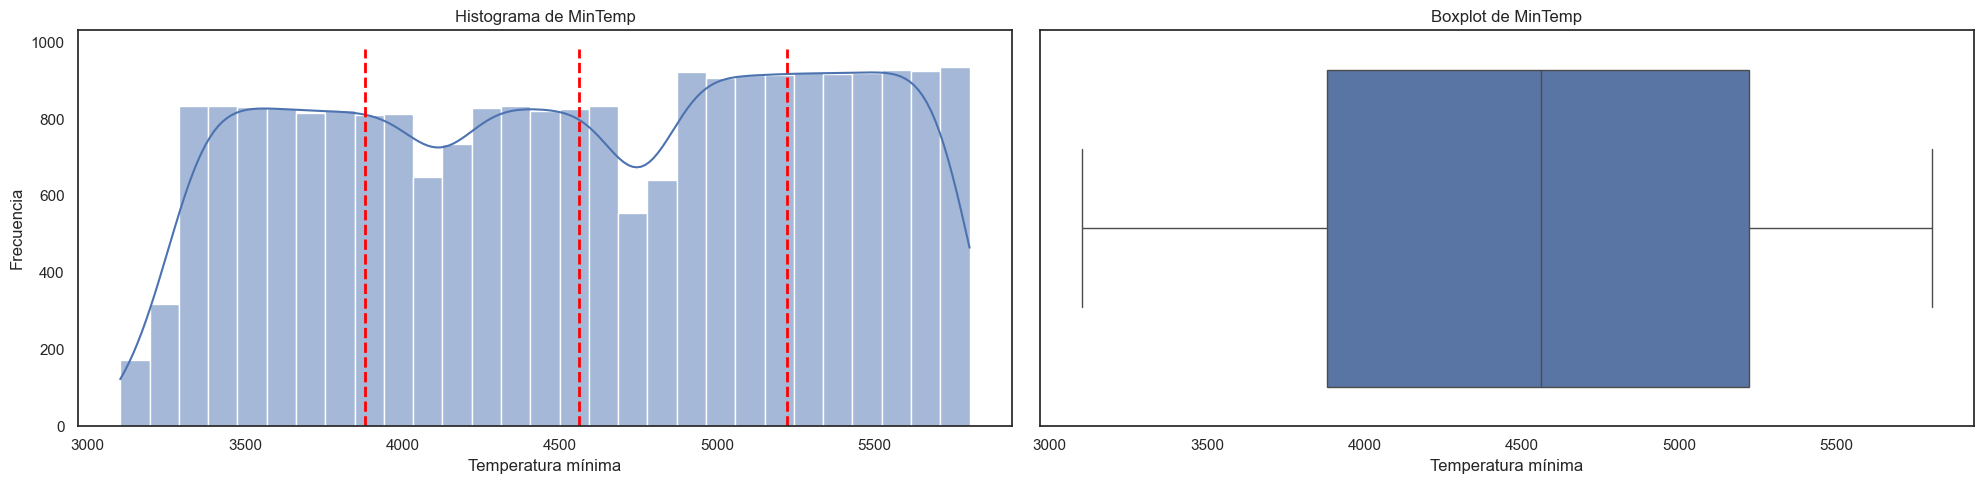

count    23017.000000
mean      4550.751836
std        757.732537
min       3104.000000
25%       3881.000000
50%       4561.000000
75%       5222.000000
max       5801.000000
Name: Date, dtype: float64

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Date'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MinTemp')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Date'].quantile(0.25)
q2 = train['Date'].quantile(0.5)
q3 = train['Date'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Date'], ax=axs[1])
axs[1].set_title('Boxplot de MinTemp')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()

train['Date'].describe()

### MinTemp

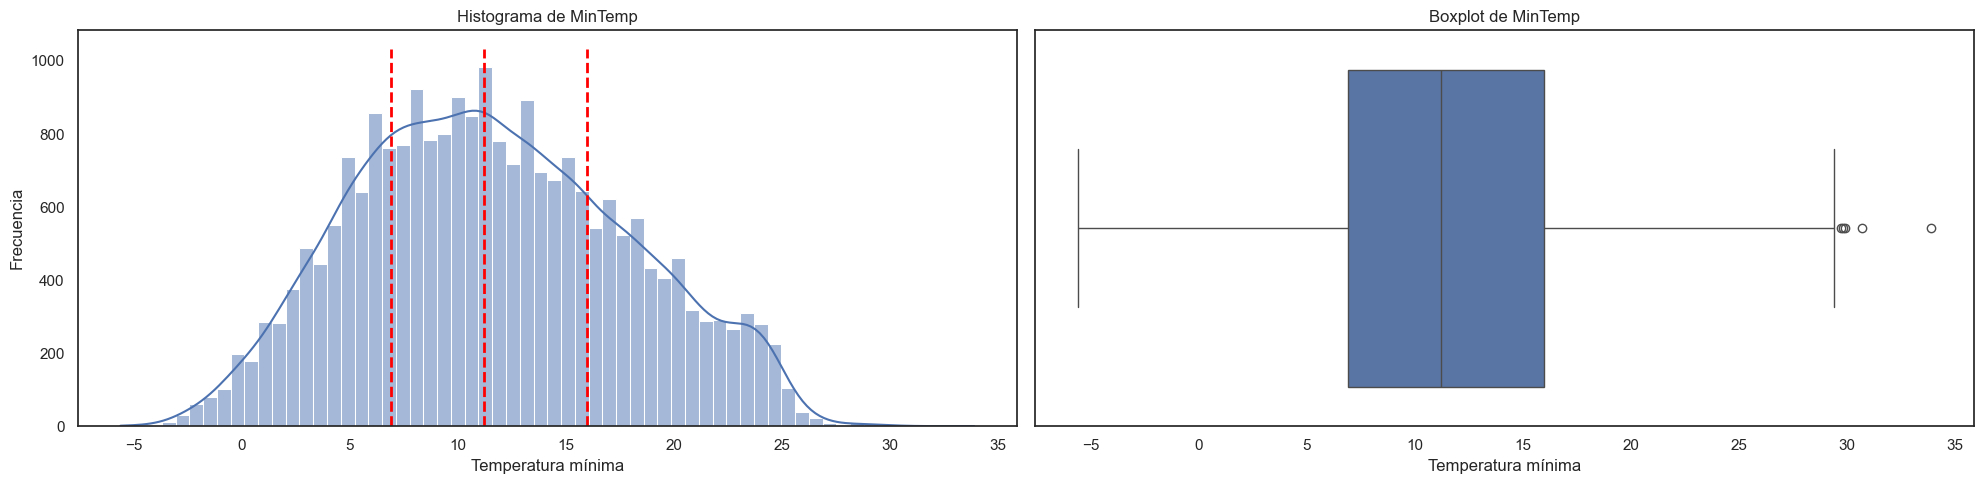

count    22985.000000
mean        11.593557
std          6.263596
min         -5.600000
25%          6.900000
50%         11.200000
75%         16.000000
max         33.900000
Name: MinTemp, dtype: float64

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['MinTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MinTemp')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['MinTemp'].quantile(0.25)
q2 = train['MinTemp'].quantile(0.5)
q3 = train['MinTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['MinTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MinTemp')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()

train['MinTemp'].describe()

La variable MinTemp posee una distribución normal, predominando una temperatura de 10/12° aproximadamente. La misma, tiene picos de 31, y minimos de -4°, siendo estos casos extremos.

### MaxTemp

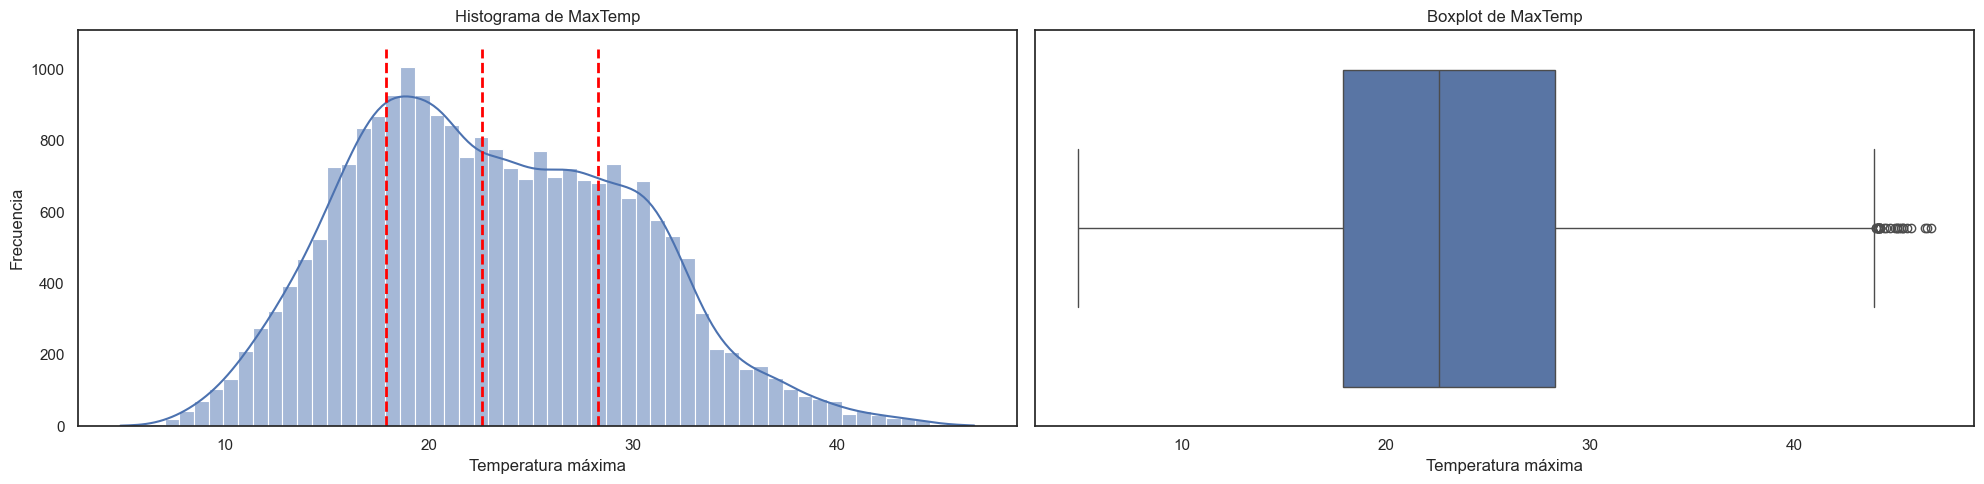

count    23002.000000
mean        23.127302
std          6.849431
min          4.900000
25%         17.900000
50%         22.600000
75%         28.300000
max         46.700000
Name: MaxTemp, dtype: float64

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['MaxTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MaxTemp')
axs[0].set_xlabel('Temperatura máxima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['MaxTemp'].quantile(0.25)
q2 = train['MaxTemp'].quantile(0.5)
q3 = train['MaxTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['MaxTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MaxTemp')
axs[1].set_xlabel('Temperatura máxima')

plt.tight_layout()
plt.show()

train['MaxTemp'].describe()


La variable MaxTemp posee una distribución normal con sesgo a la derecha, predominando una temperatura maxima de 23° aproximadamente. La misma, tiene picos de 45° y minimos de 4°, pudiendo considerarse estos mismos como Outliers

### Rainfall

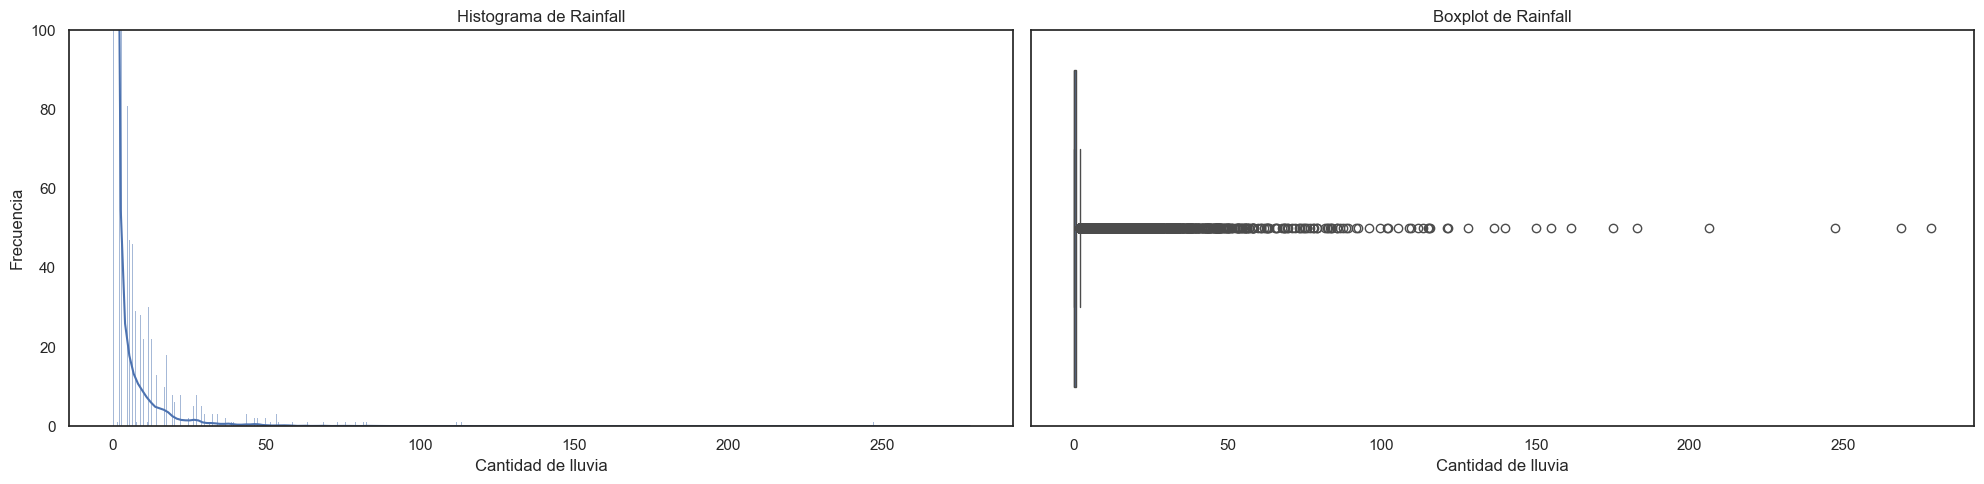

In [96]:
# Crear el gráfico
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Cantidad de lluvia')
axs[0].set_ylabel('Frecuencia')
axs[0].set_ylim(0, 100)  # Limitar la escala de frecuencia a 1000

# Boxplot
sns.boxplot(x=train['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Cantidad de lluvia')

plt.tight_layout()
plt.show()


### Evaporation

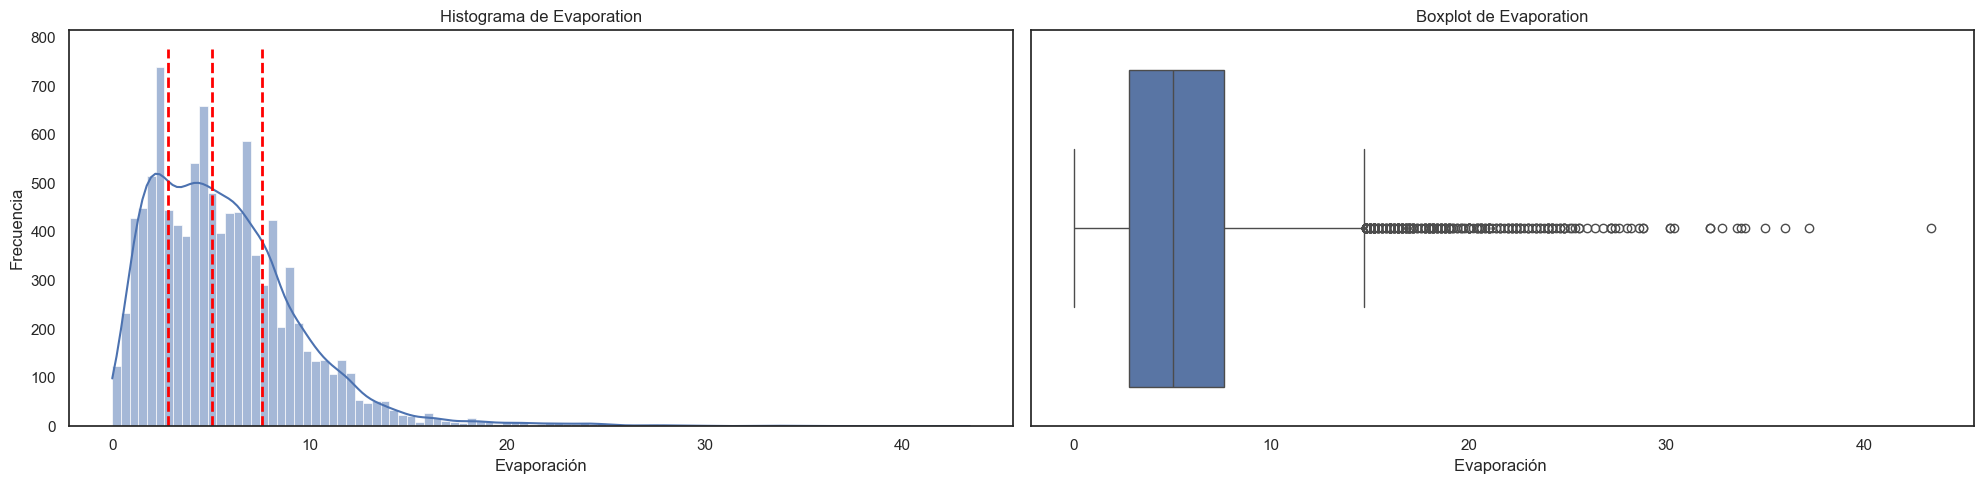

count    10384.000000
mean         5.708109
std          3.908979
min          0.000000
25%          2.800000
50%          5.050000
75%          7.600000
max         43.400000
Name: Evaporation, dtype: float64

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Evaporation'], kde=True, ax=axs[0])

# Calcular cuartiles
q1 = train['Evaporation'].quantile(0.25)
q2 = train['Evaporation'].quantile(0.5)
q3 = train['Evaporation'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

axs[0].set_title('Histograma de Evaporation')
axs[0].set_xlabel('Evaporación')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=train['Evaporation'], ax=axs[1])
axs[1].set_title('Boxplot de Evaporation')
axs[1].set_xlabel('Evaporación ')

plt.tight_layout()
plt.show()

train['Evaporation'].describe()



Como podemos ver, nuestra variable Evaporation tiene una gran cantidad de Outliers y muy distribuidos unos respectos de otros, los cuales debemos tener en cuenta a la hora del entrenamiento dado que si consideramos quitarlos, podríamos perder gran información valiosa.

### Sunshine

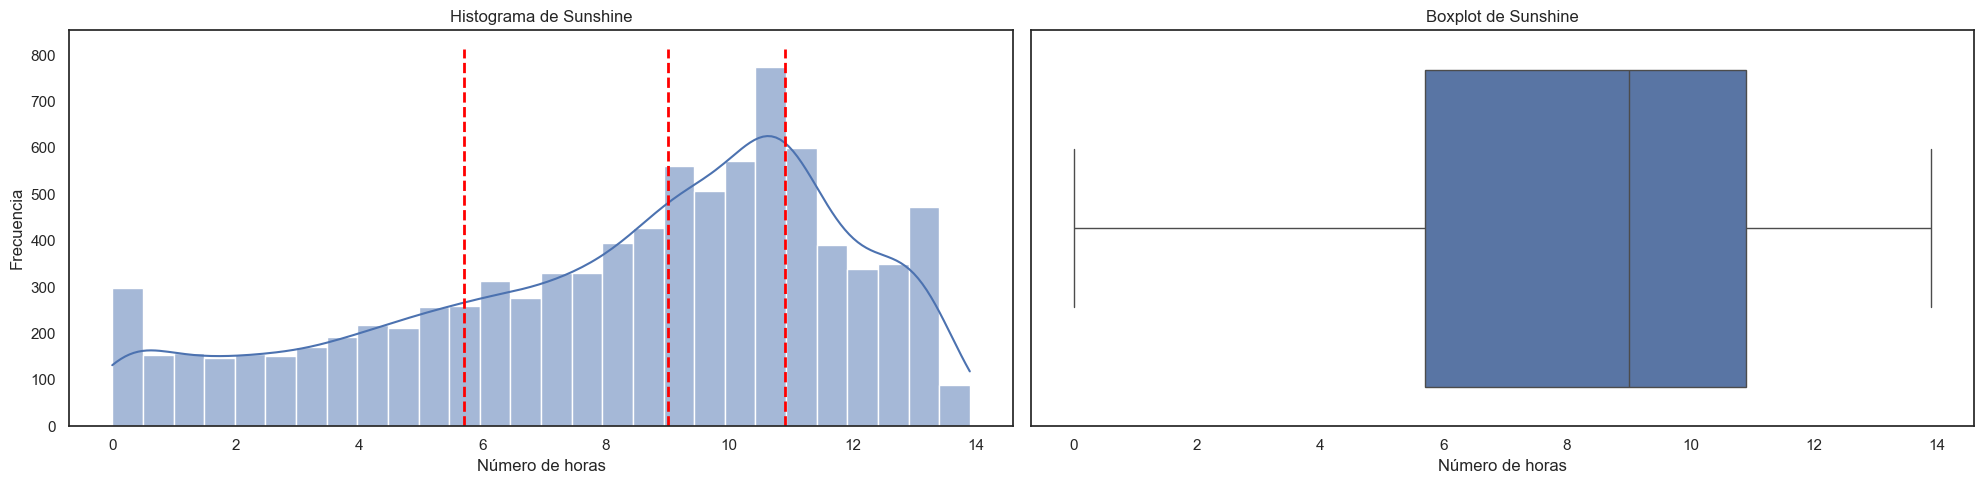

count    9098.000000
mean        8.184260
std         3.612719
min         0.000000
25%         5.700000
50%         9.000000
75%        10.900000
max        13.900000
Name: Sunshine, dtype: float64

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Sunshine'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Sunshine')
axs[0].set_xlabel('Número de horas')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Sunshine'].quantile(0.25)
q2 = train['Sunshine'].quantile(0.5)
q3 = train['Sunshine'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Sunshine'], ax=axs[1])
axs[1].set_title('Boxplot de Sunshine')
axs[1].set_xlabel('Número de horas')

plt.tight_layout()
plt.show()

train['Sunshine'].describe()

### WindGustDir

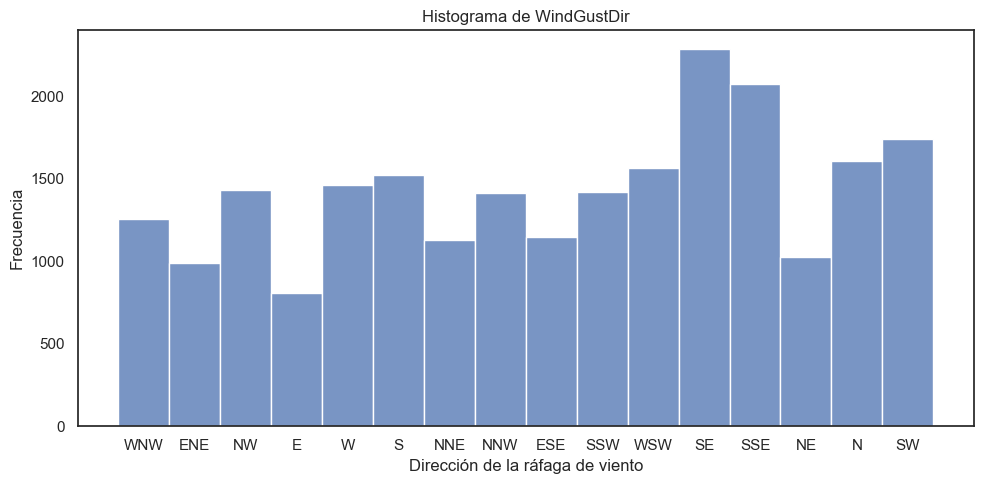

count     22899
unique       16
top          SE
freq       2287
Name: WindGustDir, dtype: object

In [99]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['WindGustDir'])
axs.set_title('Histograma de WindGustDir')
axs.set_xlabel('Dirección de la ráfaga de viento')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['WindGustDir'].describe()

### WindGustSpeed

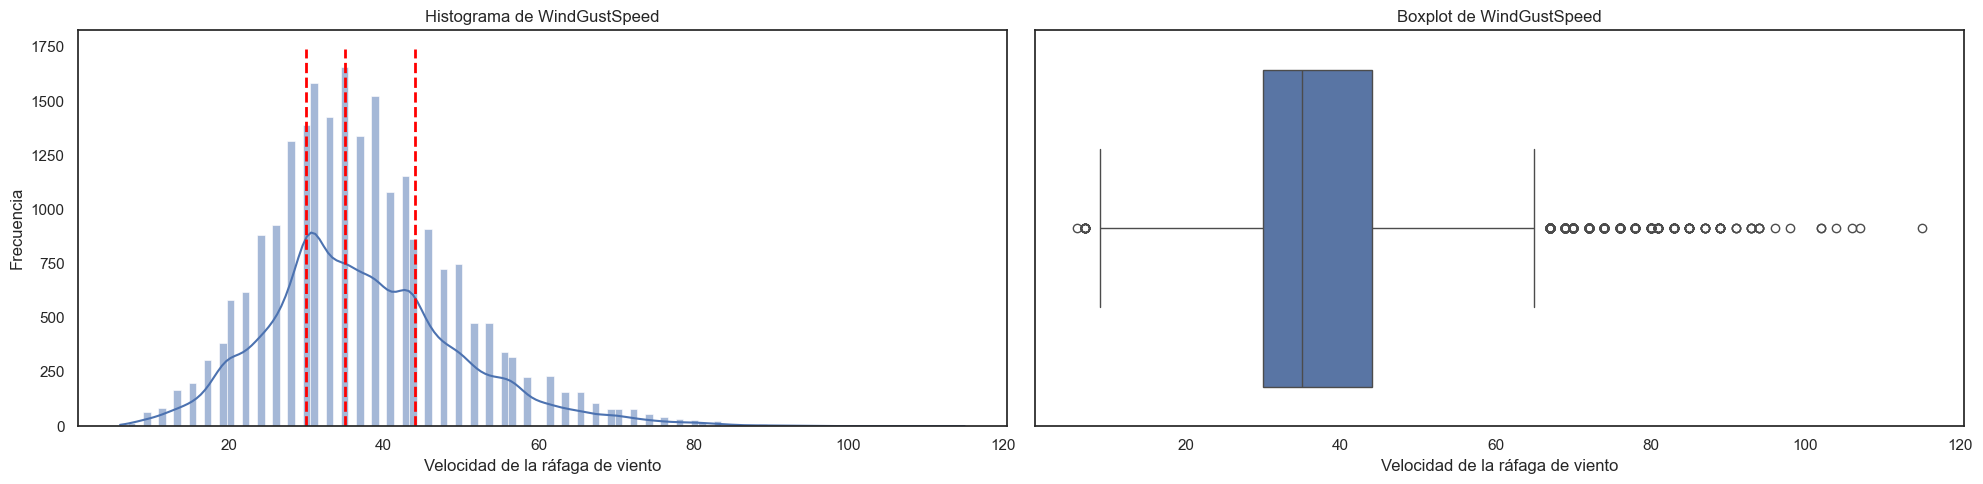

count    22904.000000
mean        37.388360
std         12.517154
min          6.000000
25%         30.000000
50%         35.000000
75%         44.000000
max        115.000000
Name: WindGustSpeed, dtype: float64

In [100]:

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['WindGustSpeed'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindGustSpeed')
axs[0].set_xlabel('Velocidad de la ráfaga de viento')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['WindGustSpeed'].quantile(0.25)
q2 = train['WindGustSpeed'].quantile(0.5)
q3 = train['WindGustSpeed'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['WindGustSpeed'], ax=axs[1])
axs[1].set_title('Boxplot de WindGustSpeed')
axs[1].set_xlabel('Velocidad de la ráfaga de viento')

plt.tight_layout()
plt.show()
train['WindGustSpeed'].describe()

### WindDir9am

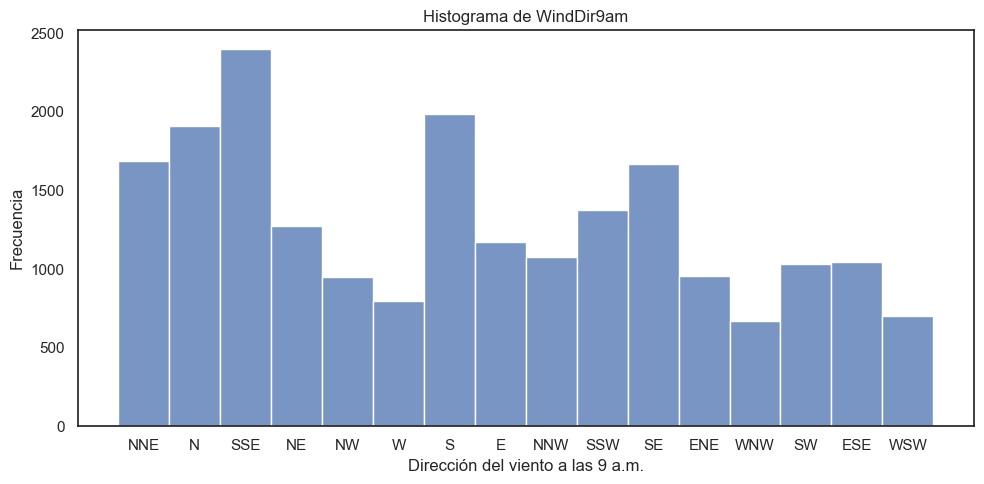

count     20717
unique       16
top         SSE
freq       2399
Name: WindDir9am, dtype: object

In [101]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['WindDir9am'])
axs.set_title('Histograma de WindDir9am')
axs.set_xlabel('Dirección del viento a las 9 a.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['WindDir9am'].describe()

### WindDir3pm

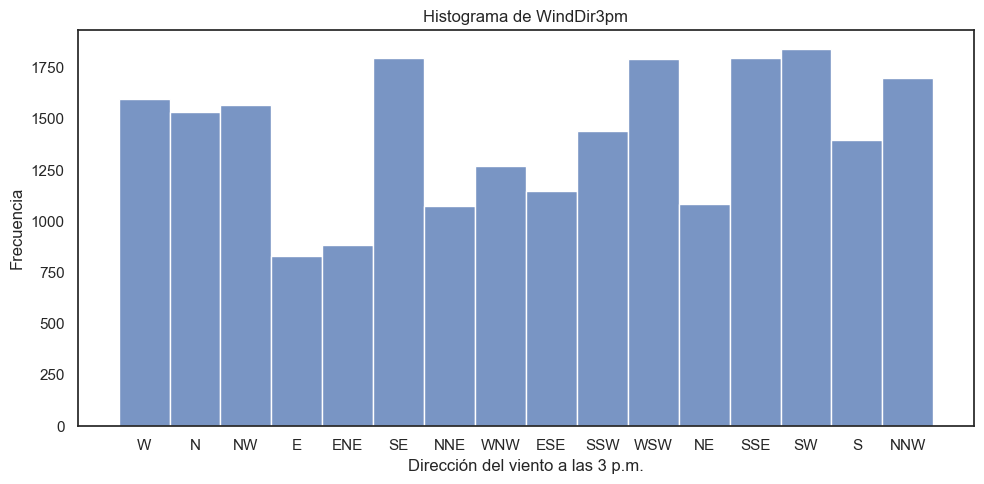

count     22759
unique       16
top          SW
freq       1840
Name: WindDir3pm, dtype: object

In [102]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['WindDir3pm'])
axs.set_title('Histograma de WindDir3pm')
axs.set_xlabel('Dirección del viento a las 3 p.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['WindDir3pm'].describe()

### WindSpeed9am

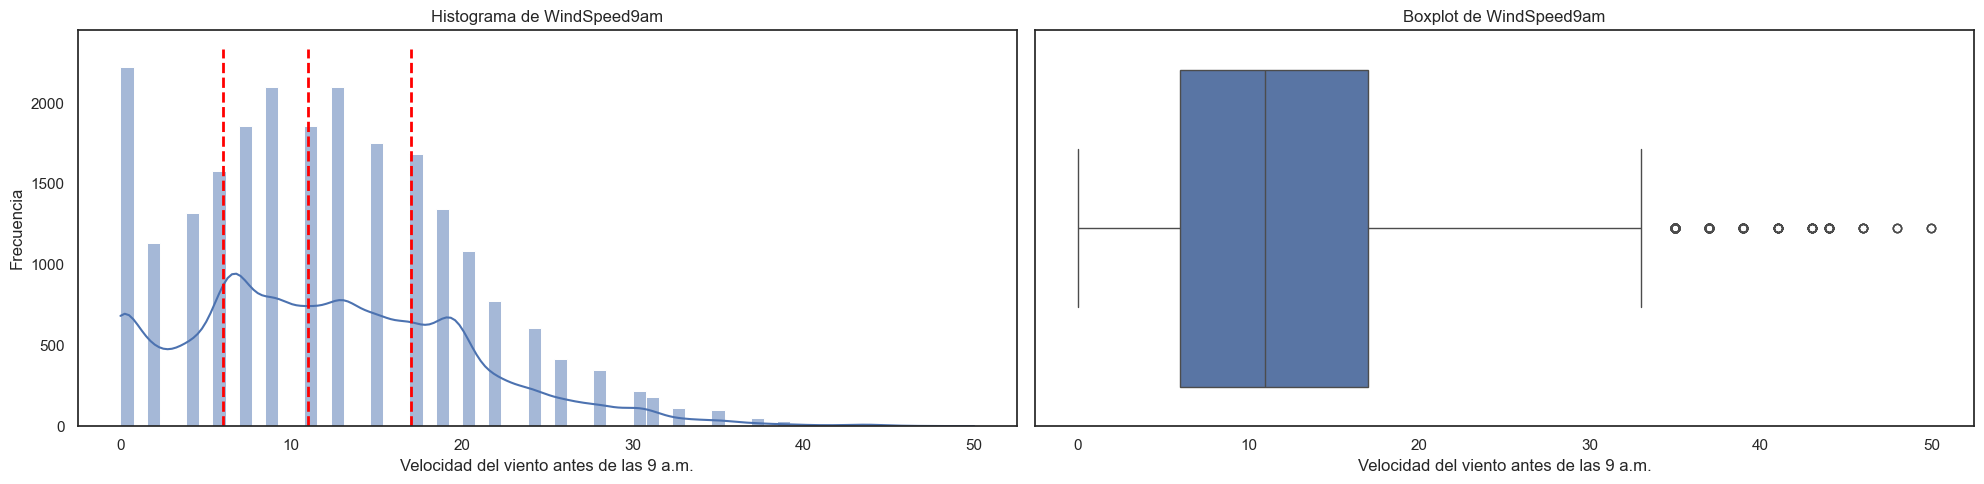

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['WindSpeed9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed9am')
axs[0].set_xlabel('Velocidad del viento antes de las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['WindSpeed9am'].quantile(0.25)
q2 = train['WindSpeed9am'].quantile(0.5)
q3 = train['WindSpeed9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['WindSpeed9am'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed9am')
axs[1].set_xlabel('Velocidad del viento antes de las 9 a.m.')

plt.tight_layout()
plt.show()


### WindSpeed3pm

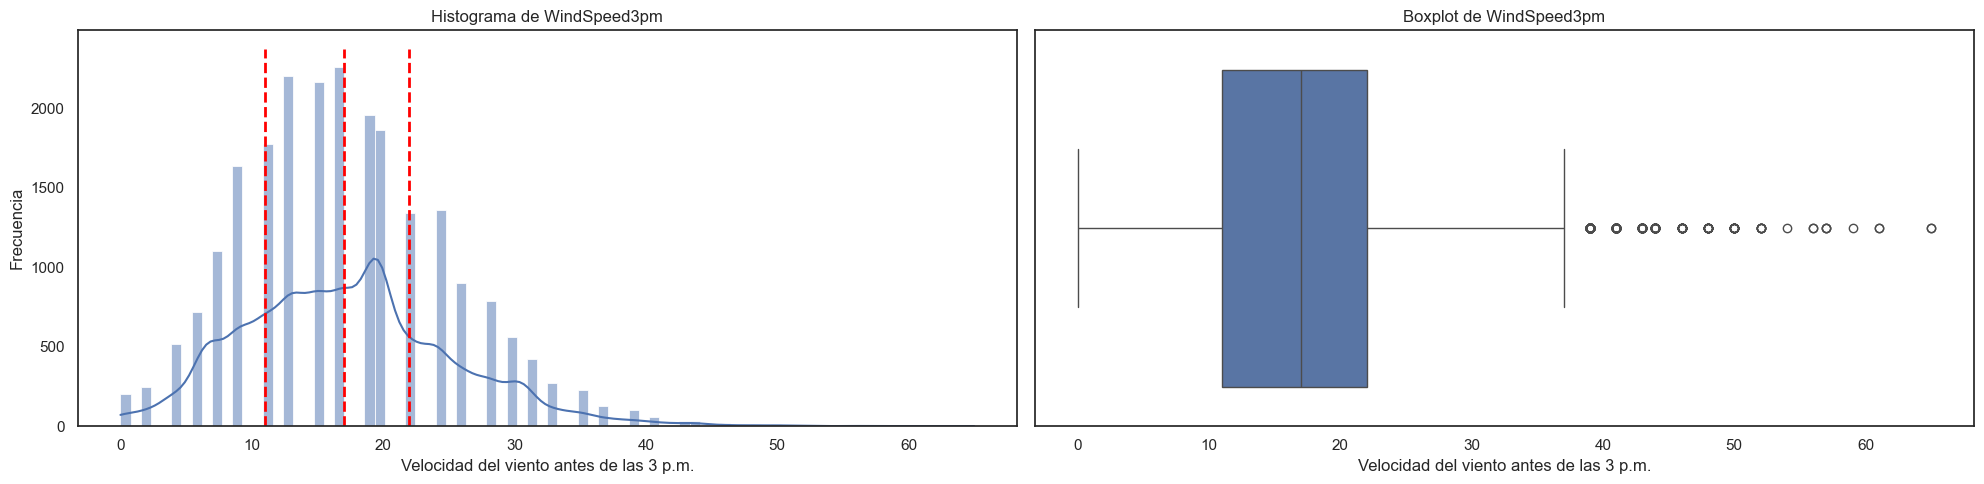

count    22962.000000
mean        17.199808
std          8.024242
min          0.000000
25%         11.000000
50%         17.000000
75%         22.000000
max         65.000000
Name: WindSpeed3pm, dtype: float64

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['WindSpeed3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed3pm')
axs[0].set_xlabel('Velocidad del viento antes de las 3 p.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['WindSpeed3pm'].quantile(0.25)
q2 = train['WindSpeed3pm'].quantile(0.5)
q3 = train['WindSpeed3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['WindSpeed3pm'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed3pm')
axs[1].set_xlabel('Velocidad del viento antes de las 3 p.m.')

plt.tight_layout()
plt.show()

train['WindSpeed3pm'].describe()

### Humidity9am

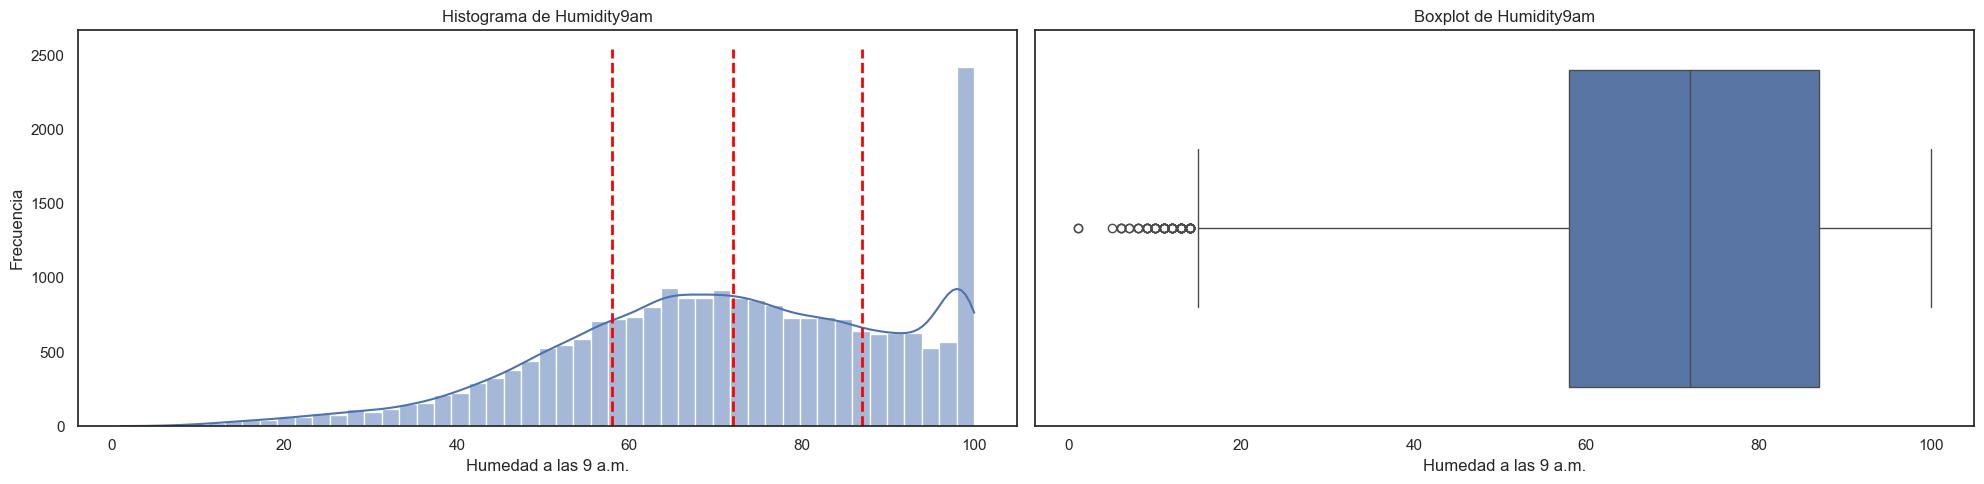

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Humidity9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity9am')
axs[0].set_xlabel('Humedad a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['Humidity9am'].quantile(0.25)
q2 = train['Humidity9am'].quantile(0.5)
q3 = train['Humidity9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Humidity9am'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity9am')
axs[1].set_xlabel('Humedad a las 9 a.m.')

plt.tight_layout()
plt.show()



### Humidity3pm

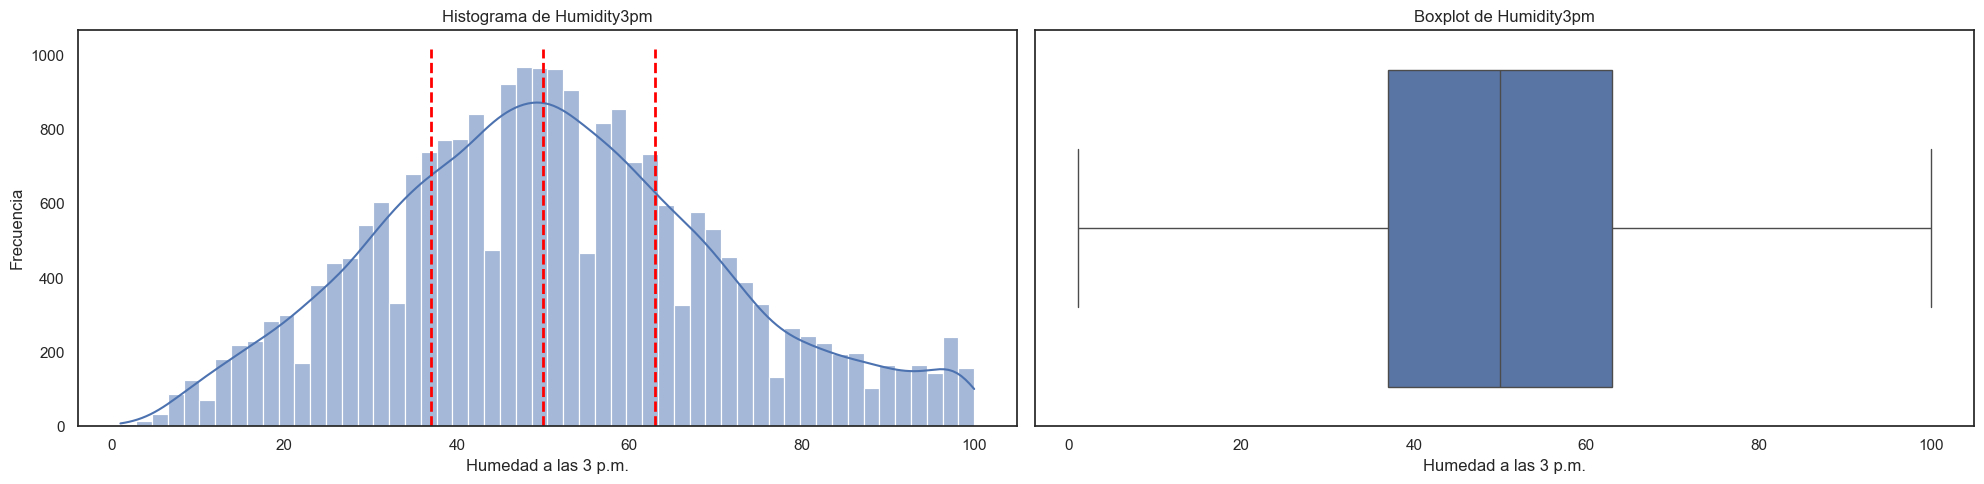

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Humidity3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity3pm')
axs[0].set_xlabel('Humedad a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['Humidity3pm'].quantile(0.25)
q2 = train['Humidity3pm'].quantile(0.5)
q3 = train['Humidity3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Humidity3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity3pm')
axs[1].set_xlabel('Humedad a las 3 p.m.')

plt.tight_layout()
plt.show()


### Pressure9am

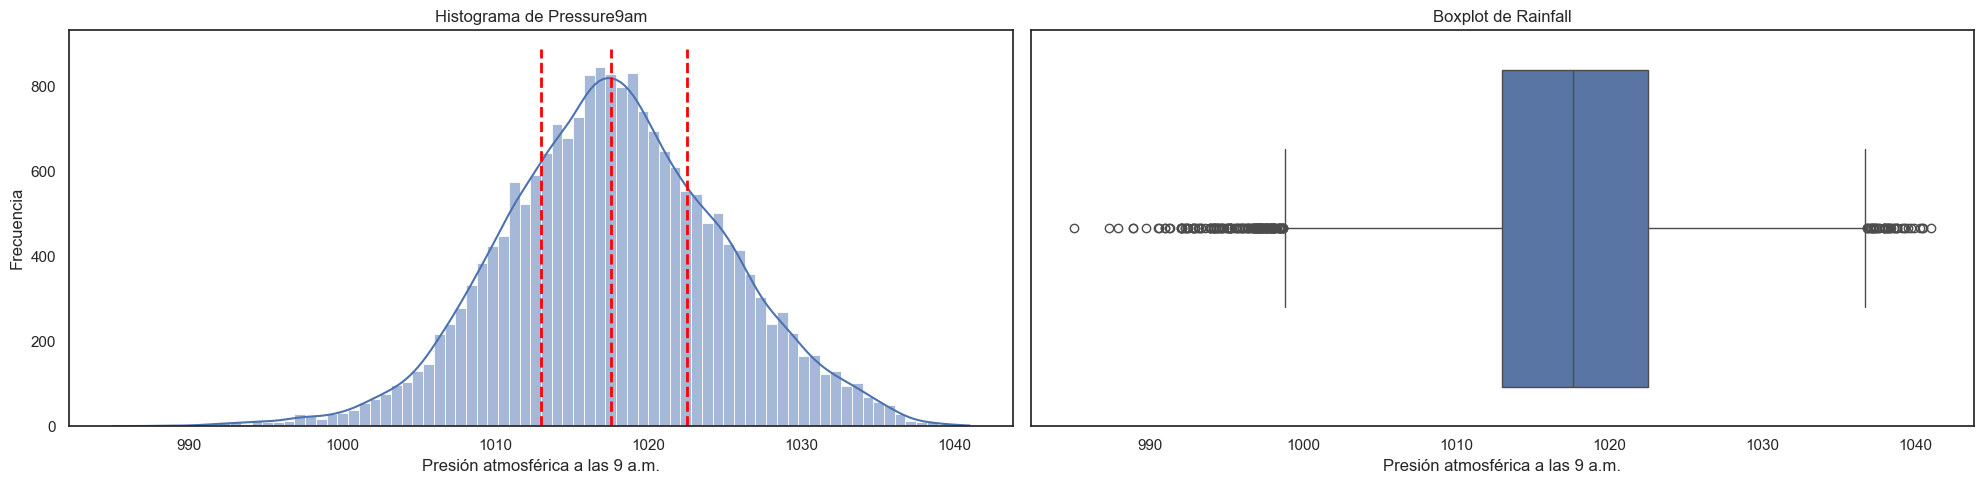

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Pressure9am'], kde=True, ax=axs[0])

axs[0].set_title('Histograma de Pressure9am')
axs[0].set_xlabel('Presión atmosférica a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['Pressure9am'].quantile(0.25)
q2 = train['Pressure9am'].quantile(0.5)
q3 = train['Pressure9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Pressure9am'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Presión atmosférica a las 9 a.m.')

plt.tight_layout()
plt.show()



### Pressure3pm

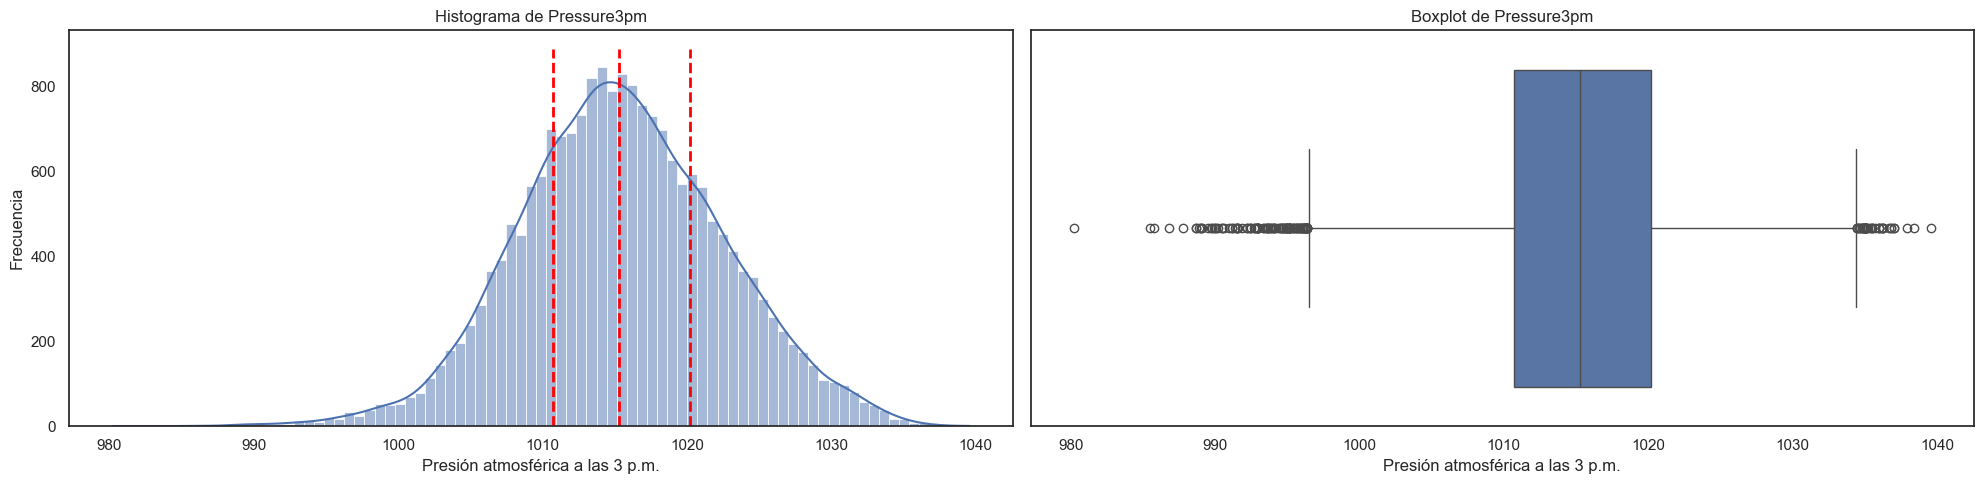

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Pressure3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Pressure3pm')
axs[0].set_xlabel('Presión atmosférica a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Pressure3pm'].quantile(0.25)
q2 = train['Pressure3pm'].quantile(0.5)
q3 = train['Pressure3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Pressure3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Pressure3pm')
axs[1].set_xlabel('Presión atmosférica a las 3 p.m.')

plt.tight_layout()
plt.show()



### Cloud9am

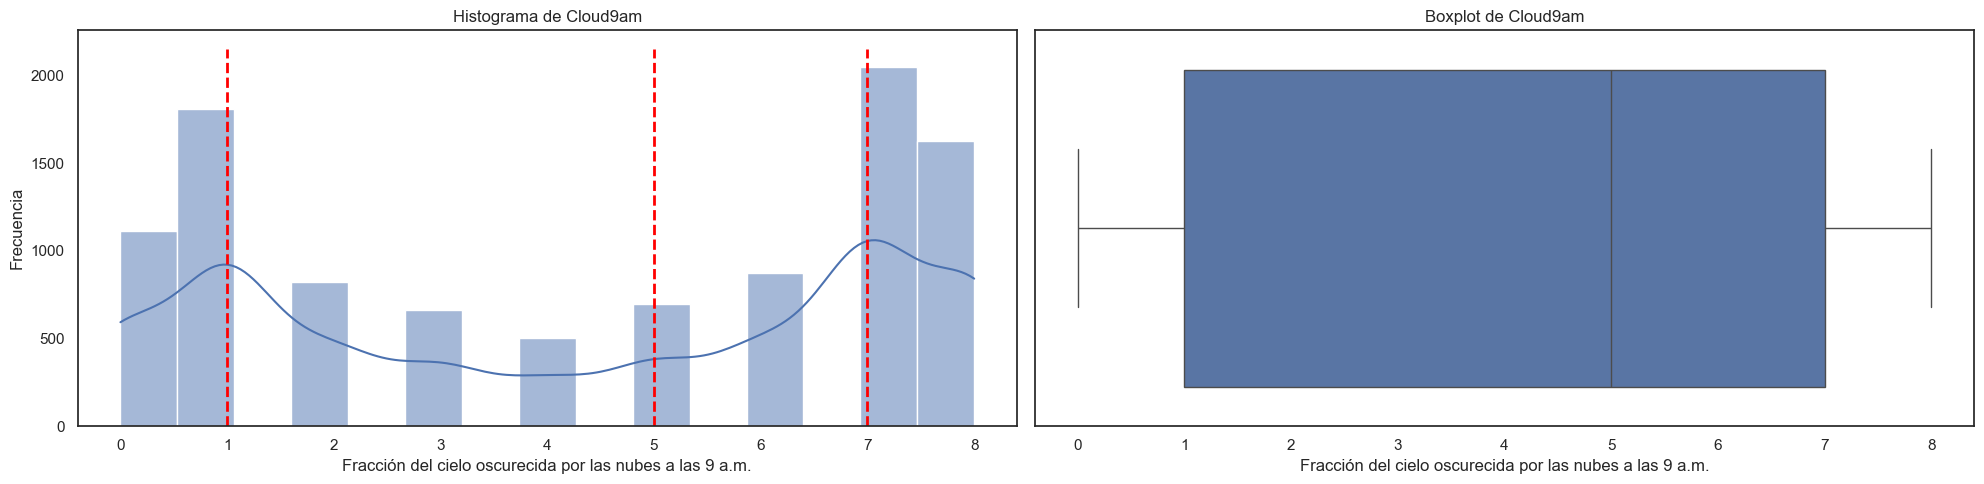

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))


# Histograma
sns.histplot(train['Cloud9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud9am')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Cloud9am'].quantile(0.25)
q2 = train['Cloud9am'].quantile(0.5)
q3 = train['Cloud9am'].quantile(0.75)


# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Cloud9am'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud9am')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')

plt.tight_layout()
plt.show()



### Cloud3pm

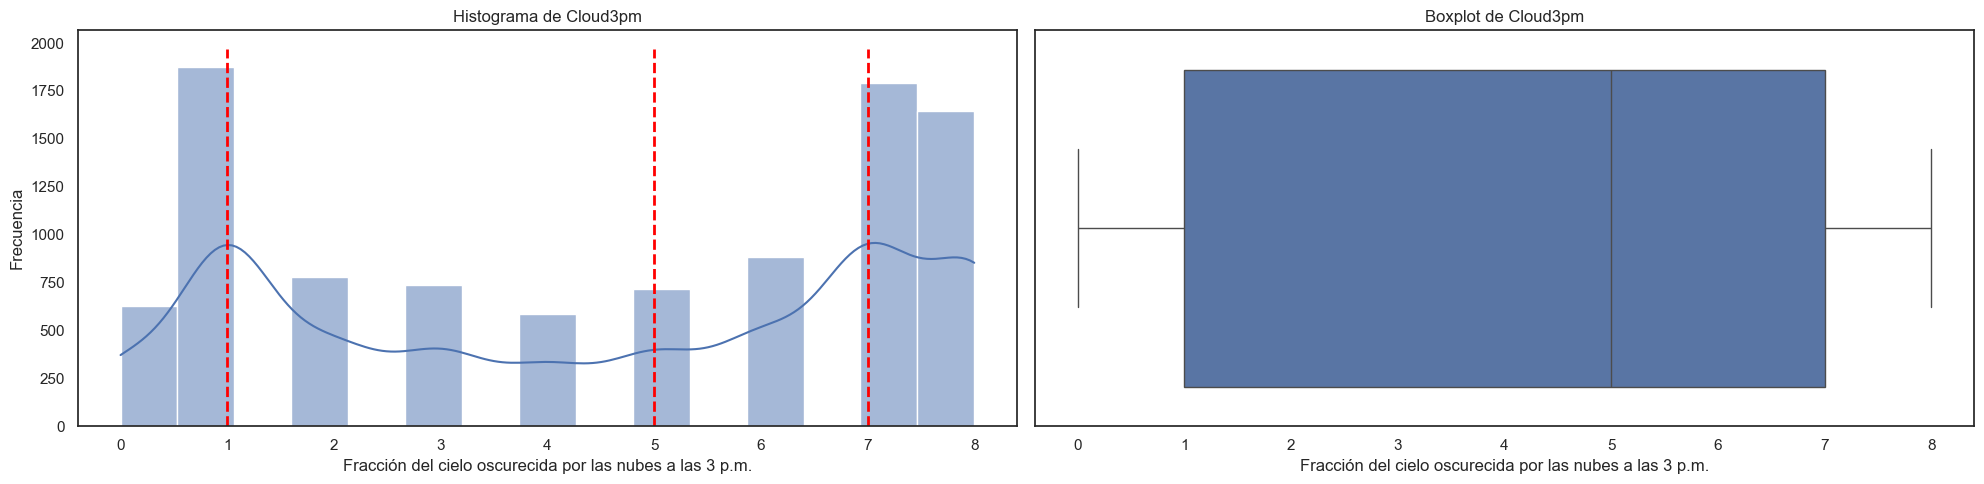

count    9646.000000
mean        4.417271
std         2.803713
min         0.000000
25%         1.000000
50%         5.000000
75%         7.000000
max         8.000000
Name: Cloud3pm, dtype: float64

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Cloud3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud3pm')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Cloud3pm'].quantile(0.25)
q2 = train['Cloud3pm'].quantile(0.5)
q3 = train['Cloud3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Cloud3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud3pm')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')

plt.tight_layout()
plt.show()

train['Cloud3pm'].describe()

### Temp9am

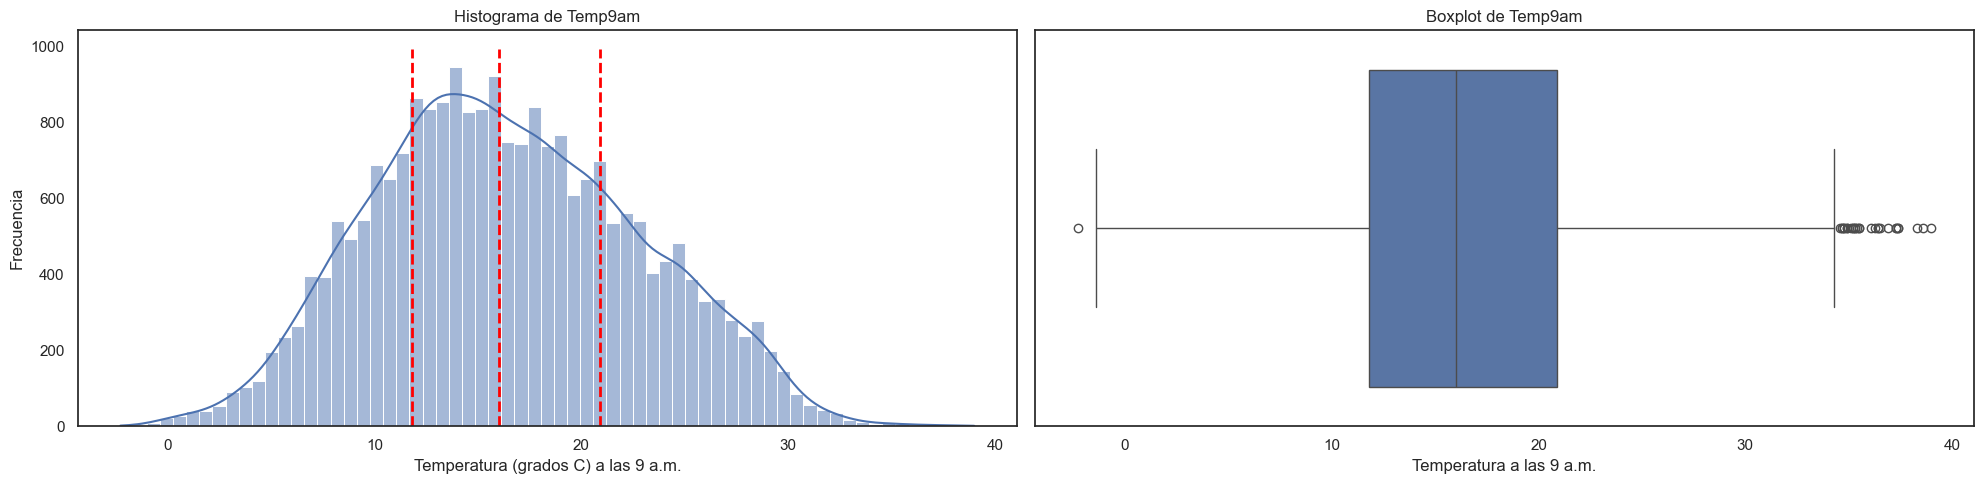

count    22946.000000
mean        16.400388
std          6.413732
min         -2.300000
25%         11.800000
50%         16.000000
75%         20.900000
max         39.000000
Name: Temp9am, dtype: float64

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Temp9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp9am')
axs[0].set_xlabel('Temperatura (grados C) a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Temp9am'].quantile(0.25)
q2 = train['Temp9am'].quantile(0.5)
q3 = train['Temp9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Temp9am'], ax=axs[1])
axs[1].set_title('Boxplot de Temp9am')
axs[1].set_xlabel('Temperatura a las 9 a.m.')

plt.tight_layout()
plt.show()

train['Temp9am'].describe()

### Temp3pm

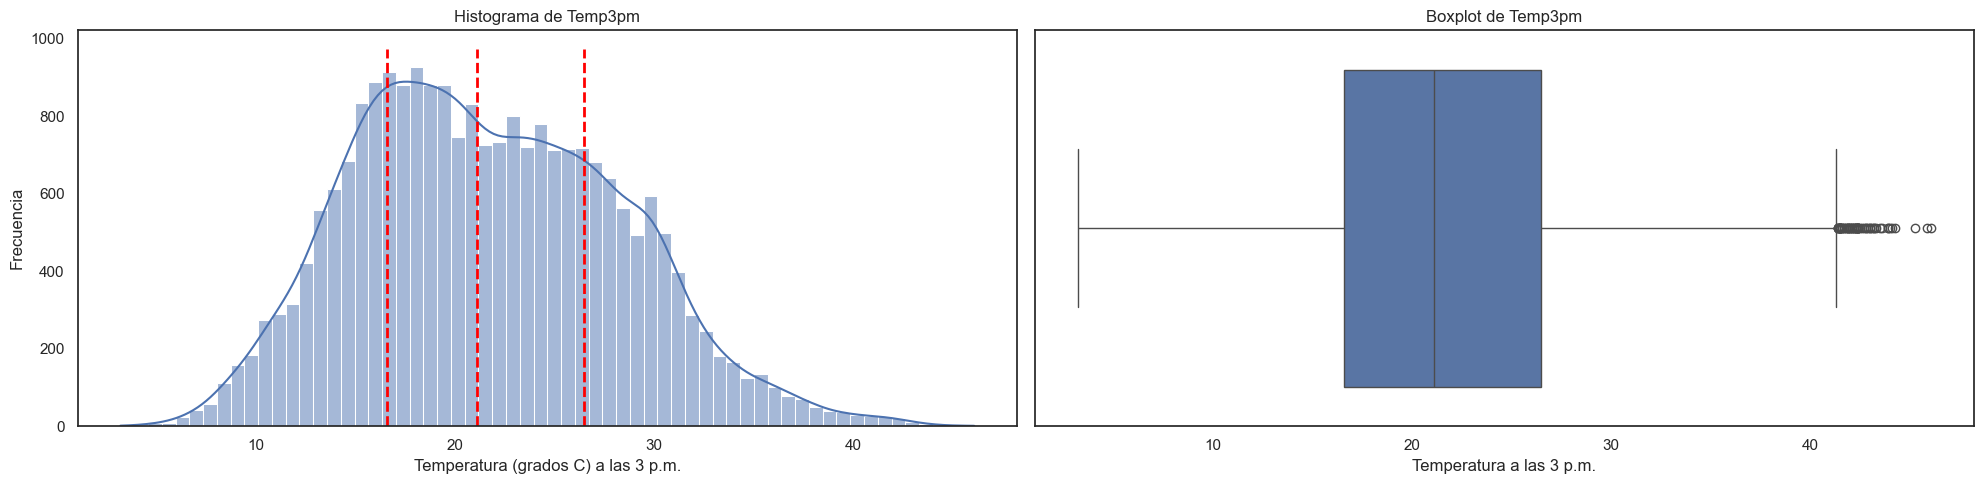

count    22960.000000
mean        21.659673
std          6.685800
min          3.200000
25%         16.600000
50%         21.100000
75%         26.500000
max         46.100000
Name: Temp3pm, dtype: float64

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))


# Histograma
sns.histplot(train['Temp3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp3pm')
axs[0].set_xlabel('Temperatura (grados C) a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Temp3pm'].quantile(0.25)
q2 = train['Temp3pm'].quantile(0.5)
q3 = train['Temp3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Temp3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Temp3pm')
axs[1].set_xlabel('Temperatura a las 3 p.m.')

plt.tight_layout()
plt.show()

train['Temp3pm'].describe()

### RainToday

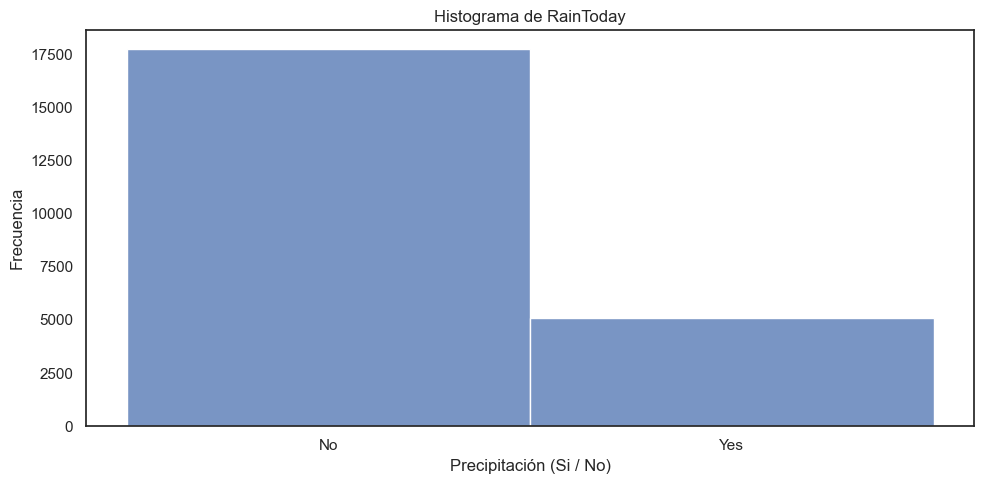

count     22821
unique        2
top          No
freq      17734
Name: RainToday, dtype: object

In [113]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['RainToday'])
axs.set_title('Histograma de RainToday')
axs.set_xlabel('Precipitación (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['RainToday'].describe()

### RainTomorrow

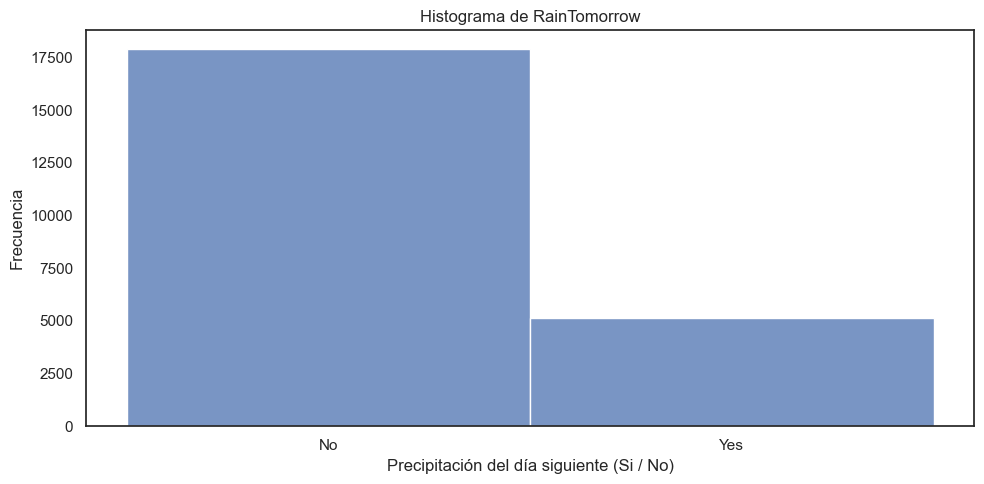

count     23017
unique        2
top          No
freq      17888
Name: RainTomorrow, dtype: object

In [114]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['RainTomorrow'])
axs.set_title('Histograma de RainTomorrow')
axs.set_xlabel('Precipitación del día siguiente (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['RainTomorrow'].describe()

### Analisis y observaciones luego de la vizualisacion de los datos

Las siguientes caracteristicas presentan valores atípicos: , **MinTemp**, **MaxTemp**, **Rainfall**, **Evaporation**, **WindGustSpeed**, **WindSpeed9am**, **WindSpeed3pm**, **Humidity9am**, **Pressure9am**, **Pressure3pm**, **Temp9am** y **Temp3pm**.

Los valores atípicos pueden sesgar los parámetros del modelo al desviar la línea de regresión, afectando la relación general entre las variables. Podemos optar por tratarlos o no. Si decidimos tratarlos, debemos hacer una excepción con la columna RainTomorrow, que es la variable objetivo, y limitar la eliminación de outliers a un máximo del 10% del total de datos para evitar la pérdida de información valiosa y sesgar los resultados del modelo.

- Date: Fecha de observación.

        Debemos eliminarla porque no contiene información relevante.
        
- Location: El nombre de la ubicación de la estación meteorológica.

        Debemos descartar todas las ubicaciones que no nos interesen y luego las restantes asumirlas como una misma y única, para poder posteriormente eliminar Location y reducir la dimensionalidad para un modelo más simple.

- MinTemp: La temperatura mínima (°C).
- MaxTemp: La temperatura máxima (°C).

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la temperatura promedio durante el día (PromTemp = MaxTemp - MinTemp)

- Rainfall: La cantidad de lluvia registrada durante el día (mm).
- Evaporation: La evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
- Sunshine: El número de horas de sol brillante en el día.
- WindGustDir: La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindGustSpeed: La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindDir9am: Dirección del viento a las 9 a.m.
- WindDir3pm: Dirección del viento a las 3 p.m.
- WindSpeed9am: Velocidad del viento (km/h) promediada de las 9 a.m.
- WindSpeed3pm: Velocidad del viento (km/h) promediada de las 3 p.m.
- Humidity9am: Humedad (porcentaje) a las 9 a.m.
- Humidity3pm: Humedad (porcentaje) a las 3 p.m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de humedad (ΔHumidity = Humidity3pm - Humidity9am)

- Pressure9am: La presión atmosférica (hPa) a las 9 a. m.
- Pressure3pm: La presión atmosférica (hPa) a las 3 p. m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de presión atmosférica (ΔPressure = Pressure3pm - Pressure9am)

- Cloud9am: Fracción del cielo oscurecida por las nubes a las 9 a.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Cloud3pm: Fracción del cielo oscurecida por las nubes a las 3 p.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Temp9am: Temperatura (grados C) a las 9 a.m.
- Temp3pm: Temperatura (grados C) a las 3 p.m.
- RainToday: Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
- RainTomorrow: Booleano: 1 si la precipitación (mm) en las siguientes 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0

### Desbalance
El dataset está desbalanceado en la variable objetivo RainTomorrow. Hay una predominancia de la clase "No", lo que sugiere que la mayoría de los días no llovió. Esto es relevante porque entrenar un modelo en un dataset desbalanceado puede llevar a que el modelo se sesgue hacia la clase mayoritaria, afectando su capacidad de predecir correctamente la clase minoritaria ("Yes").

# Manejo de datos faltantes

**Datos numéricos:** Usaremos dos enfoques diferentes para rellenar los datos faltantes en las variables numéricas. Para las columnas con distribuciones no bimodales, utilizaremos la mediana, ya que no se ve influenciada por valores atípicos y es más robusta en conjuntos de datos con valores extremos. Para las columnas detectadas con distribuciones bimodales, emplearemos un imputador basado en KNN (`KNNImputer`), que aprovecha las relaciones entre características para realizar una imputación más informada y adecuada.

**Datos categóricos:** Usaremos la moda para rellenar los datos faltantes en las variables categóricas. La moda representa la categoría más frecuente y asume que los valores faltantes pertenecen a esta categoría, proporcionando una solución sencilla pero efectiva cuando no hay más información disponible.

### Completado de datos de Train

In [115]:

# Identificar columnas numéricas y categóricas
numeric_cols = train.select_dtypes(include=np.number).columns
categorical_cols = train.select_dtypes(include='object').columns


In [116]:

# Columnas con distribuciones bimodales
bimodal_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
                   'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
                   'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

# Imputar con mediana para columnas no bimodales
non_bimodal_columns = [col for col in train.select_dtypes(include=['float64', 'int64']).columns if col not in bimodal_columns]


In [117]:
from sklearn.impute import KNNImputer

for col in non_bimodal_columns:
    train[col].fillna(train[col].median(), inplace=True)

# Imputar con KNN para columnas bimodales
knn_imputer = KNNImputer(n_neighbors=5)
train[bimodal_columns] = knn_imputer.fit_transform(train[bimodal_columns])


C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\3373215346.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col].fillna(train[col].median(), inplace=True)
C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\3373215346.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[bimodal_columns] = knn_imputer.fit_transform(train[bimodal_columns])


In [118]:

# Imputar con moda para columnas categóricas
for col in train.select_dtypes(include=['object']).columns:
    train[col].fillna(train[col].mode()[0], inplace=True)


C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\3813415309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col].fillna(train[col].mode()[0], inplace=True)


In [119]:

# Verificar valores faltantes restantes
print("Valores faltantes después de la imputación:")
print(train.isnull().sum())

Valores faltantes después de la imputación:
Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


In [120]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].isnull().sum()

WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

In [121]:
columns_to_check = [col for col in train.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
train[columns_to_check].isnull().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

### Completado de datos de Test

- Usamos estadísticas calculadas del conjunto de entrenamiento para rellenar los datos faltantes del conjunto de prueba. Esto asegura consistencia y evita fugas de datos.
- Se reutiliza el imputador entrenado con los datos de entrenamiento para imputar las columnas bimodales del conjunto de prueba.

In [122]:
# Imputar con mediana para columnas numéricas no bimodales en el conjunto de test
for col in non_bimodal_columns:
    test[col].fillna(train[col].median(), inplace=True)  # Usar la mediana del conjunto de entrenamiento

# Imputar con KNN para columnas bimodales en el conjunto de test
test[bimodal_columns] = knn_imputer.transform(test[bimodal_columns])  # Usar el imputador entrenado con el conjunto de entrenamiento

# Imputar con moda para columnas categóricas en el conjunto de test
for col in categorical_cols:
    test[col].fillna(train[col].mode()[0], inplace=True)  # Usar la moda del conjunto de entrenamiento

# Verificar valores faltantes restantes en test
print("Valores faltantes después de la imputación en test (por columna):")
print(test.isnull().sum())


C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\985624217.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col].fillna(train[col].median(), inplace=True)  # Usar la mediana del conjunto de entrenamiento


Valores faltantes después de la imputación en test (por columna):
Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\985624217.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[bimodal_columns] = knn_imputer.transform(test[bimodal_columns])  # Usar el imputador entrenado con el conjunto de entrenamiento
C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\985624217.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col].fillna(train[col].mode()[0], inplace=True)  # Usar la moda del conjunto de entrenamiento


### guardar imputers

In [123]:
import joblib

# Serializar KNNImputer
joblib.dump(knn_imputer, 'docker/model/knn_imputer.joblib')

# Serializar medianas para columnas no bimodales
median_values = train[non_bimodal_columns].median().to_dict()
joblib.dump(median_values, 'docker/model/median_values.joblib')

# Serializar modas para columnas categóricas
mode_values = train[categorical_cols].mode().iloc[0].to_dict()
joblib.dump(mode_values, 'docker/model/mode_values.joblib')


['docker/model/mode_values.joblib']

In [124]:
import joblib

# Cargar KNNImputer
knn_imputer = joblib.load('docker/model/knn_imputer.joblib')

# Cargar medianas para columnas no bimodales
median_values = joblib.load('docker/model/median_values.joblib')

# Cargar modas para columnas categóricas
mode_values = joblib.load('docker/model/mode_values.joblib')


# One hot enconding (Dummies)

Simplifiqué las 16 categorías de direcciones de viento de mi DataFrame agrupándolas en 4 principales: 'N', 'S', 'E' y 'W'. Usé un diccionario para mapear las direcciones originales a las nuevas, y apliqué este mapeo a la columna usando `map` de pandas, reduciendo así las categorías de 16 a 4 para facilitar el análisis.

## Dummies de Train

In [125]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
train['WindGustDir'] = train['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
train['WindDir9am'] = train['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
train['WindDir3pm'] = train['WindDir3pm'].map(diccionario_invertido)

C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\1098054911.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['WindGustDir'] = train['WindGustDir'].map(diccionario_invertido)
C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\1098054911.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['WindDir9am'] = train['WindDir9am'].map(diccionario_invertido)
C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\1098054911.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [126]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
24128,W,N,W,No,No
24129,E,N,N,No,No
24130,N,N,N,No,No
24131,E,S,E,No,No
24132,E,N,E,No,No
...,...,...,...,...,...
135482,N,N,N,No,No
135483,N,N,N,No,No
135484,N,S,N,No,No
135485,N,N,N,No,No


Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [127]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
train_dummies = pd.get_dummies(train, columns=columns_to_dummy, drop_first=True)

Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [128]:
train_dummies.replace({True: 1, False: 0}, inplace=True)

In [129]:
train_dummies

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
24128,3257,15.2,32.6,0.0,13.20,8.86,59.0,13.0,22.0,35.0,...,0,1,1,0,0,0,0,1,0,0
24129,3258,15.0,31.7,0.0,5.64,10.12,28.0,13.0,15.0,64.0,...,0,0,1,0,0,1,0,0,0,0
24130,3259,15.9,33.4,0.0,11.52,9.70,52.0,9.0,30.0,63.0,...,0,0,1,0,0,1,0,0,0,0
24131,3260,17.2,24.8,0.0,5.96,9.80,35.0,9.0,19.0,71.0,...,0,0,0,1,0,0,0,0,0,0
24132,3261,17.8,32.2,0.0,2.86,7.58,28.0,7.0,15.0,97.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135482,5797,8.5,20.2,0.0,3.36,9.16,33.0,6.0,20.0,70.0,...,0,0,1,0,0,1,0,0,0,0
135483,5798,12.6,21.9,0.0,5.24,6.90,37.0,9.0,22.0,73.0,...,0,0,1,0,0,1,0,0,0,0
135484,5799,8.2,24.0,0.0,3.64,4.20,37.0,2.0,9.0,76.0,...,0,0,0,1,0,1,0,0,0,0
135485,5800,9.2,22.7,0.0,5.28,9.30,39.0,11.0,26.0,67.0,...,0,0,1,0,0,1,0,0,0,0


## Dummies de Test

In [130]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
test['WindGustDir'] = test['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
test['WindDir9am'] = test['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
test['WindDir3pm'] = test['WindDir3pm'].map(diccionario_invertido)

C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\1802969872.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['WindGustDir'] = test['WindGustDir'].map(diccionario_invertido)
C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\1802969872.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['WindDir9am'] = test['WindDir9am'].map(diccionario_invertido)
C:\Users\brisa\AppData\Local\Temp\ipykernel_24260\1802969872.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [131]:
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
26583,N,N,N,No,No
26584,S,W,E,No,No
26585,N,S,N,No,No
26586,S,N,S,No,No
26587,N,N,N,No,No
...,...,...,...,...,...
136066,N,E,S,Yes,No
136067,N,E,N,No,Yes
136068,W,N,N,Yes,Yes
136069,N,S,N,Yes,No


Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [132]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
test_dummies = pd.get_dummies(test, columns=columns_to_dummy)

Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [133]:
test_dummies = pd.get_dummies(test, columns=columns_to_dummy, drop_first=True)

In [134]:
test_dummies.replace({True: 1, False: 0}, inplace=True)

In [135]:
test_dummies

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
26583,5802,19.8,41.9,0.0,10.68,10.76,57.0,6.0,37.0,69.0,...,0,0,1,0,0,1,0,0,0,0
26584,5803,18.9,23.1,0.0,8.08,5.54,30.0,4.0,20.0,64.0,...,1,0,0,0,1,0,0,0,0,0
26585,5804,16.6,22.0,0.0,4.38,3.64,24.0,4.0,4.0,69.0,...,0,0,0,1,0,1,0,0,0,0
26586,5805,15.1,30.8,0.0,4.76,11.12,35.0,6.0,22.0,67.0,...,1,0,1,0,0,0,1,0,0,0
26587,5806,17.1,30.4,0.0,6.06,10.48,37.0,11.0,11.0,70.0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136066,6381,1.7,12.6,3.0,1.80,6.36,26.0,4.0,7.0,93.0,...,0,0,0,0,0,0,1,0,1,0
136067,6382,1.5,11.1,0.0,2.32,3.90,20.0,2.0,9.0,84.0,...,0,0,0,0,0,1,0,0,0,1
136068,6383,4.7,12.8,5.4,2.24,2.02,48.0,17.0,24.0,90.0,...,0,1,1,0,0,1,0,0,1,1
136069,6384,-0.5,11.4,8.6,1.76,7.12,28.0,2.0,15.0,96.0,...,0,0,0,1,0,1,0,0,1,0


# Matriz de correlación

## Matriz de correlación numérica

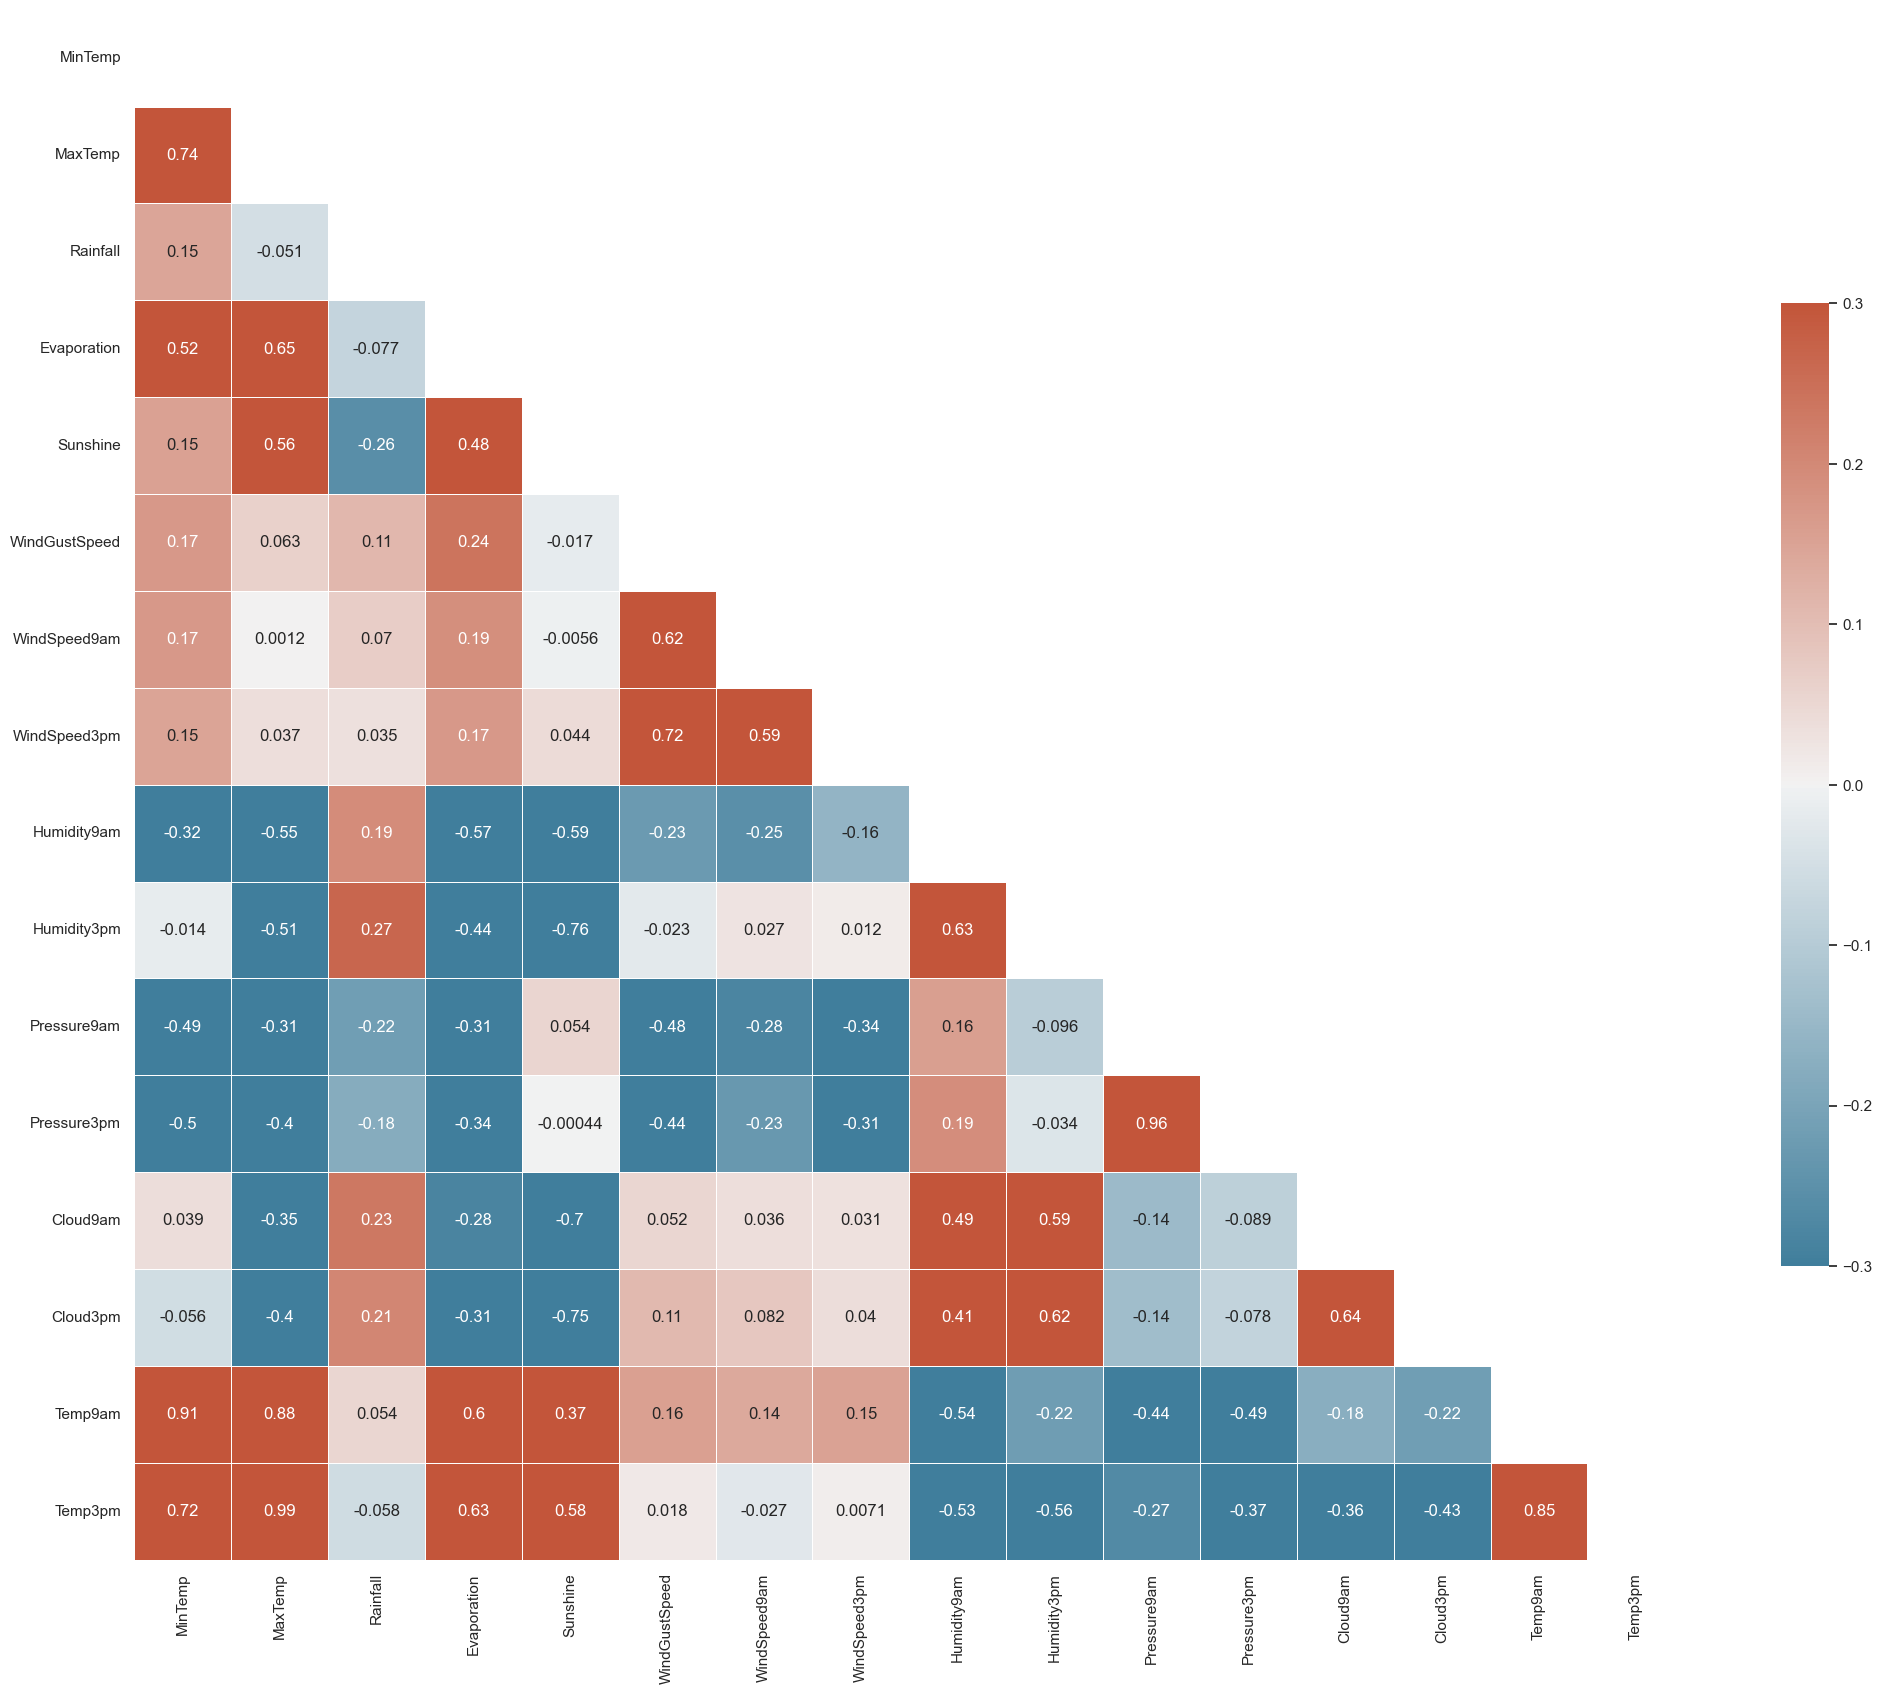

In [136]:
sns.set_theme(style="white")
# Creación de la matriz de correlación
corr = train_dummies[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


## Matriz de correlación categórica

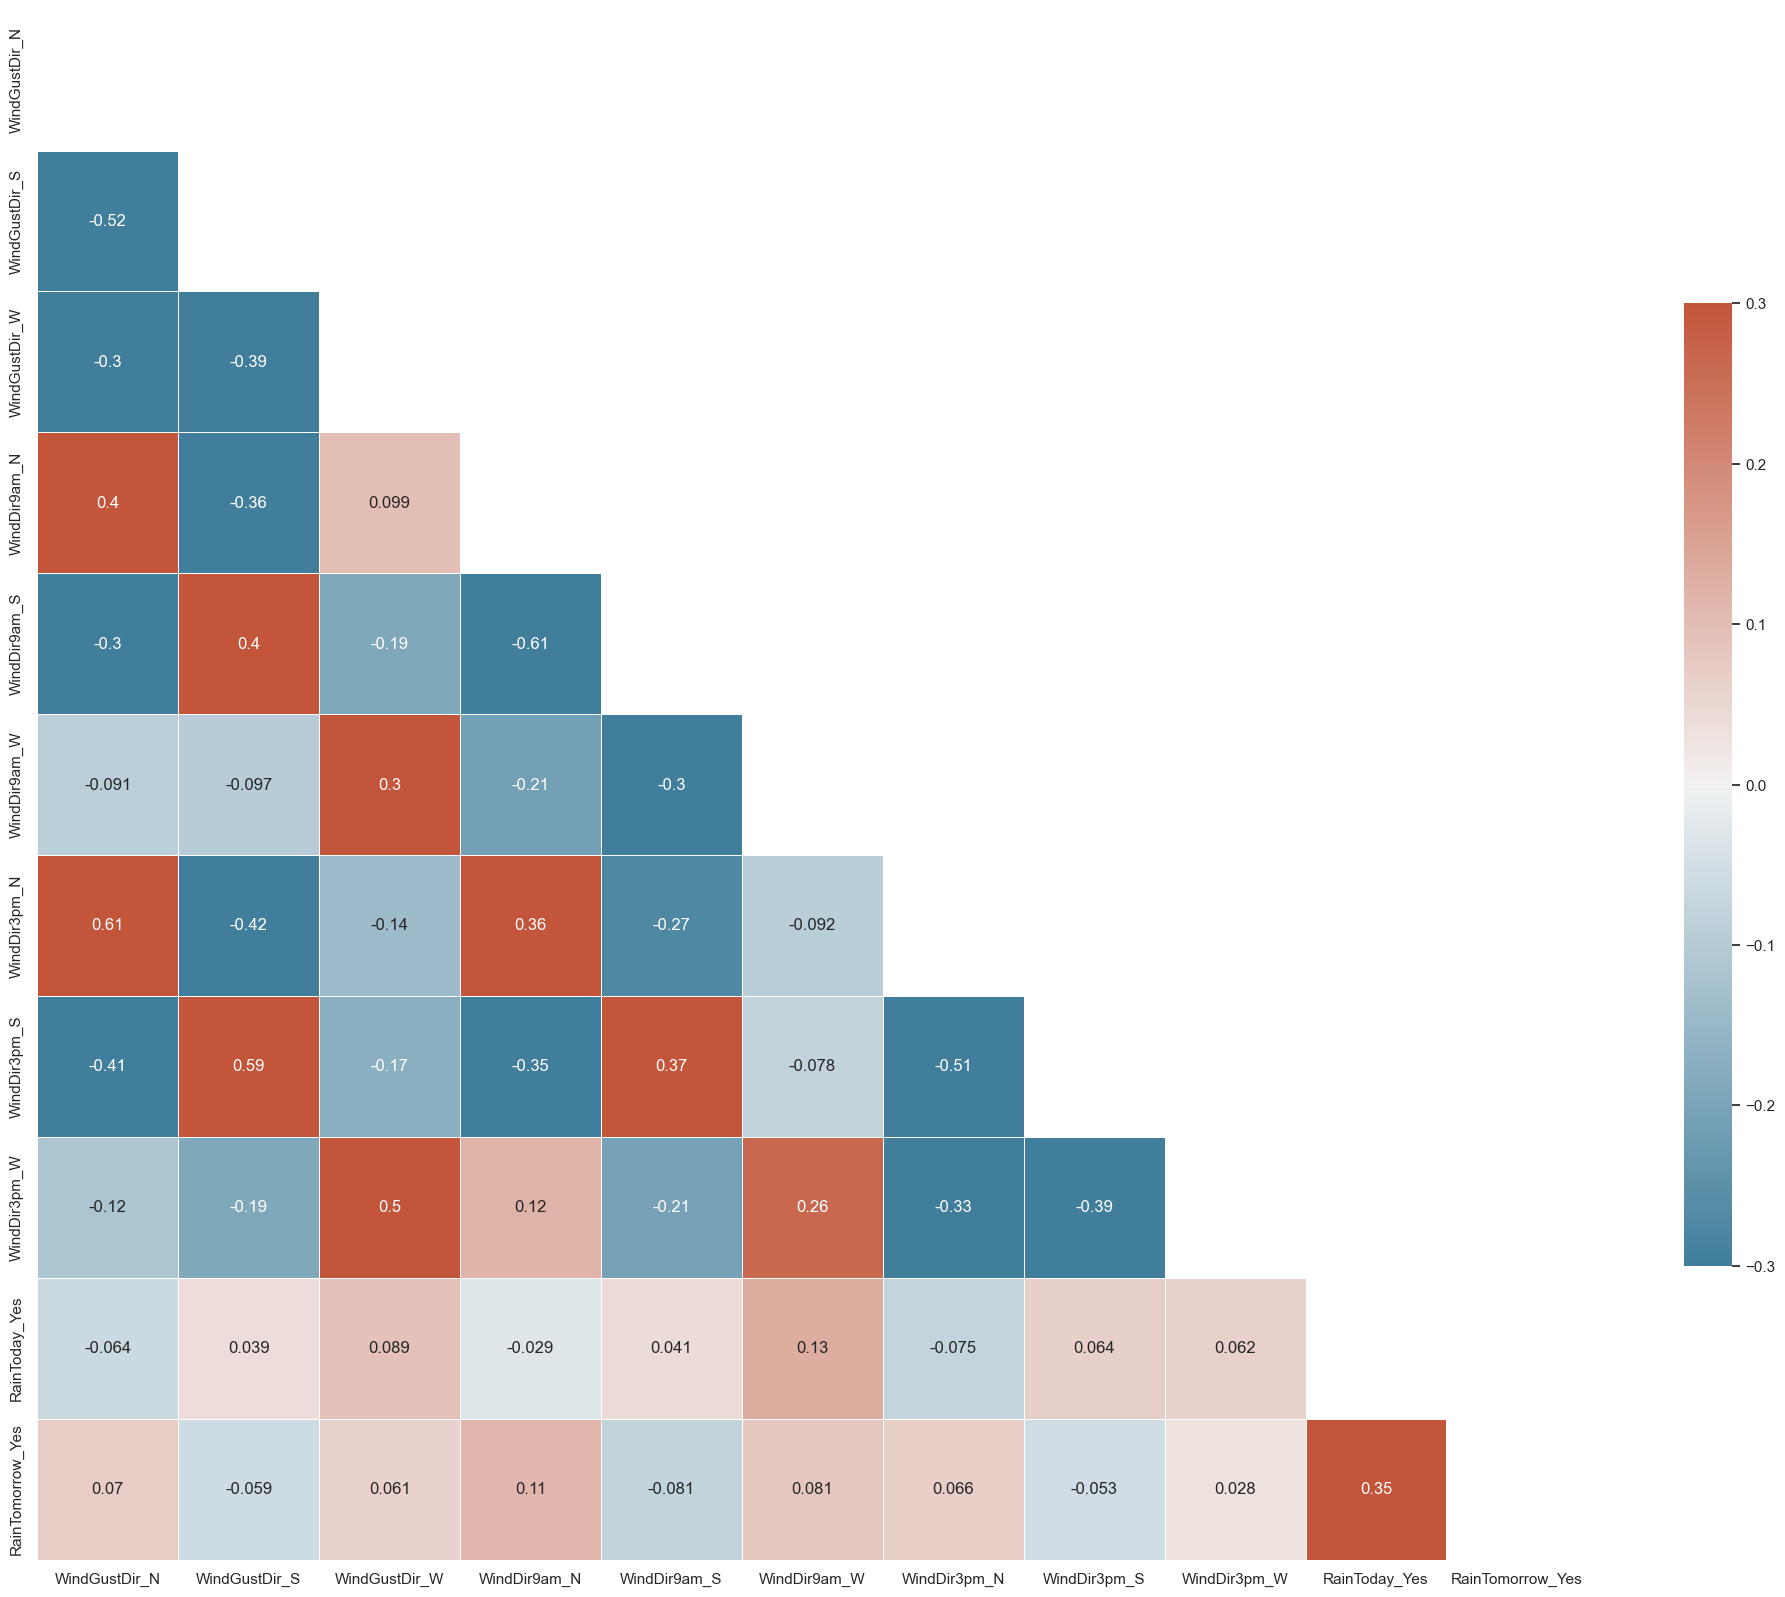

In [137]:
sns.set_theme(style="white")

# Calcular la matriz de correlación
corr = train_dummies[['WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainTomorrow_Yes']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


La razón por la cual realizamos la matriz de correlación solo en el conjunto de entrenamiento (train) y no en el de prueba (test) es para evitar lo que se conoce como data leakage.

- **Data leakage** ocurre cuando utilizas información del conjunto de prueba (test) para tomar decisiones durante el entrenamiento del modelo.

# Estandarización

Estandarizamos las características porque pueden tener diferentes rangos de valores.
Estandarizarlas asegura que todas las características tengan la misma escala, lo que evita que las características
con mayores rangos dominen el modelo.

In [138]:
# Crear el estandarizador
scaler = StandardScaler()

## Estandarización de Train

In [139]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
# Aplicar la estandarización a las columnas seleccionadas
train_dummies[columns_to_standardize] = scaler.fit_transform(train_dummies[columns_to_standardize])

In [140]:
train_dummies

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
24128,3257,0.576106,1.383503,-0.272951,2.429357,0.447820,1.726684,0.119161,0.599108,-1.903443,...,0,1,1,0,0,0,0,1,0,0
24129,3258,0.544158,1.252072,-0.272951,0.185046,0.825242,-0.750619,0.119161,-0.273896,-0.381228,...,0,0,1,0,0,1,0,0,0,0
24130,3259,0.687923,1.500330,-0.272951,1.930621,0.699435,1.167293,-0.371502,1.596827,-0.433718,...,0,0,1,0,0,1,0,0,0,0
24131,3260,0.895584,0.244436,-0.272951,0.280044,0.729389,-0.191228,-0.371502,0.224964,-0.013797,...,0,0,0,1,0,0,0,0,0,0
24132,3261,0.991427,1.325089,-0.272951,-0.640242,0.064408,-0.750619,-0.616834,-0.273896,1.350948,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135482,5797,-0.494144,-0.427321,-0.272951,-0.491809,0.537682,-0.351054,-0.739500,0.349679,-0.066287,...,0,0,1,0,0,1,0,0,0,0
135483,5798,0.160785,-0.179063,-0.272951,0.066300,-0.139280,-0.031402,-0.371502,0.599108,0.091184,...,0,0,1,0,0,1,0,0,0,0
135484,5799,-0.542066,0.127609,-0.272951,-0.408686,-0.948041,-0.031402,-1.230164,-1.022185,0.248654,...,0,0,0,1,0,1,0,0,0,0
135485,5800,-0.382327,-0.062236,-0.272951,0.078175,0.579618,0.128424,-0.126171,1.097968,-0.223757,...,0,0,1,0,0,1,0,0,0,0


## Estandarización de Test

In [141]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

# Aplicar la estandarización a las columnas seleccionadas
test_dummies[columns_to_standardize] = scaler.transform(test_dummies[columns_to_standardize])

In [142]:
test_dummies

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
26583,5802,1.310905,2.741621,-0.272951,1.681253,1.016948,1.566858,-0.739500,2.469832,-0.118777,...,0,0,1,0,0,1,0,0,0,0
26584,5803,1.167140,-0.003822,-0.272951,0.909401,-0.546656,-0.590793,-0.984832,0.349679,-0.381228,...,1,0,0,0,1,0,0,0,0,0
26585,5804,0.799740,-0.164459,-0.272951,-0.189005,-1.115784,-1.070271,-0.984832,-1.645760,-0.118777,...,0,0,0,1,0,1,0,0,0,0
26586,5805,0.560132,1.120641,-0.272951,-0.076196,1.124783,-0.191228,-0.739500,0.599108,-0.223757,...,1,0,1,0,0,0,1,0,0,0
26587,5806,0.879610,1.062228,-0.272951,0.309730,0.933077,-0.031402,-0.126171,-0.772756,-0.066287,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136066,6381,-1.580369,-1.537181,0.088455,-0.954921,-0.301032,-0.910445,-0.984832,-1.271615,1.140988,...,0,0,0,0,0,0,1,0,1,0
136067,6382,-1.612316,-1.756232,-0.272951,-0.800550,-1.037903,-1.389923,-1.230164,-1.022185,0.668576,...,0,0,0,0,0,1,0,0,0,1
136068,6383,-1.101152,-1.507974,0.377581,-0.824299,-1.601041,0.847641,0.609825,0.848538,0.983517,...,0,1,1,0,0,1,0,0,1,1
136069,6384,-1.931794,-1.712422,0.763081,-0.966795,-0.073381,-0.750619,-1.230164,-0.273896,1.298458,...,0,0,0,1,0,1,0,0,1,0


**En el conjunto de entrenamiento:**
Se aplica fit_transform del StandardScaler para ajustar el escalador a los datos de entrenamiento y transformar esos datos.

**En el conjunto de prueba:**
Se aplica transform del StandardScaler ya ajustado para transformar los datos de prueba usando la misma media y desviación estándar que en el conjunto de entrenamiento.

Esto asegura una transformación consistente y evita la fuga de información.



In [143]:
import joblib

# Serializar scaler
joblib.dump(scaler, 'docker/model/scaler.joblib')


['docker/model/scaler.joblib']

# División del conjunto de datos de entrenamiento


In [52]:

y_train = train_dummies['RainTomorrow_Yes']
x_train = train_dummies.drop(['RainTomorrow_Yes'], axis=1)

y_test = test_dummies['RainTomorrow_Yes']
x_test = test_dummies.drop(['RainTomorrow_Yes'], axis=1)


In [53]:
x_train

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,WindGustDir_N,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes
15076,3257,0.216653,0.565559,-0.330623,0.768588,1.531304,-0.366909,-0.931121,0.016035,-1.135946,...,1,0,0,1,0,0,1,0,0,0
15077,3258,-0.302555,1.726816,-0.330623,2.004841,1.331991,-0.124710,-0.889915,0.016035,-0.100620,...,1,0,0,1,0,0,1,0,0,0
15078,3259,0.797857,1.726816,-0.330623,0.617826,0.763364,-0.067721,-1.343183,-1.825864,0.229319,...,1,0,0,1,0,0,0,1,0,0
15079,3260,1.379061,0.381857,-0.330623,0.602750,0.575776,0.103243,0.717125,0.341076,-0.225769,...,1,0,0,0,1,0,0,1,0,0
15080,3261,1.301567,1.398777,-0.330623,0.210767,-0.039747,0.188725,-1.137152,-1.262460,0.855065,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144868,5794,2.057132,3.202991,-0.330623,3.241093,1.373026,0.331196,0.408079,-0.850741,-3.126956,...,1,0,0,0,0,0,0,0,1,0
144869,5795,2.463975,2.596119,-0.330623,2.140527,1.220611,0.473666,1.335217,0.557770,-2.842526,...,0,1,0,0,0,0,0,0,0,0
144870,5796,1.785904,2.120463,-0.330623,2.246061,1.367164,0.473666,1.541248,0.016035,-3.013184,...,0,0,0,0,0,0,0,1,0,0
144871,5797,1.320941,2.235276,-0.330623,1.778697,1.308543,0.188725,1.541248,0.557770,-3.297614,...,0,0,0,0,0,0,0,1,0,0


In [54]:
y_train

15076     0
15077     0
15078     0
15079     0
15080     0
         ..
144868    0
144869    0
144870    0
144871    0
144872    0
Name: RainTomorrow_Yes, Length: 22388, dtype: int64

# Balanceamos los datos:
Realizamos un balanceo de datos en el conjunto de entrenamiento utilizando la técnica SMOTETomek. 

In [55]:
from imblearn.combine import SMOTETomek

# Aplicar SMOTETomek solo al conjunto de entrenamiento
smote_tomek = SMOTETomek(random_state=42)

# Asegurarse de que y_train no sea un DataFrame
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]

# Reemplazar directamente X_train y y_train con los datos balanceados
x_train, y_train = smote_tomek.fit_resample(x_train, y_train)

# El conjunto de prueba se mantiene sin cambios
x_test, y_test = x_test, y_test  # No hacemos nada con X_test ni y_test

# Verificar las formas de los datos balanceados
print("Tamaño de X_train después de SMOTETomek:", x_train.shape)
print("Tamaño de y_train después de SMOTETomek:", y_train.shape)
print("Tamaño de X_test (sin cambios):", x_test.shape)
print("Tamaño de y_test (sin cambios):", y_test.shape)


Tamaño de X_train después de SMOTETomek: (32886, 27)
Tamaño de y_train después de SMOTETomek: (32886,)
Tamaño de X_test (sin cambios): (5596, 27)
Tamaño de y_test (sin cambios): (5596,)


In [56]:
print("X_train_balanced shape:", x_train.shape)
print("y_train_encoded shape:", y_train.shape)


X_train_balanced shape: (32886, 27)
y_train_encoded shape: (32886,)


In [57]:

print("\nDistribución después del balanceo:")
print(pd.Series(y_train).value_counts(normalize=True))


Distribución después del balanceo:
RainTomorrow_Yes
0    0.5
1    0.5
Name: proportion, dtype: float64


El método **SMOTETomek** combina **SMOTE**, que genera datos sintéticos para la clase minoritaria, con **Tomek Links**, que elimina datos redundantes de la clase mayoritaria. Esto balancea los datos mejorando la representación de la clase minoritaria y limpiando el ruido en la mayoritaria.

Se justifica su uso porque:
1. **Maneja desbalance de clases**: Evita que el modelo se sesgue hacia la clase mayoritaria.
2. **Mejora el aprendizaje**: Permite límites de decisión más claros y mejor desempeño en métricas como sensibilidad y F1-Score.
3. **Generaliza bien**: Los datos balanceados son más representativos para el entrenamiento.

El conjunto de prueba permanece sin cambios para evaluar el modelo con la distribución original, asegurando resultados realistas. 

# Regresión Logística (Clasificación).


In [58]:
# Inicializar y entrenar un modelo de regresión logística
model = LogisticRegression()
start = time.time()
model.fit(x_train, np.ravel(y_train))
end = time.time()

no_opt_time = end - start

# Realizar predicciones en el conjunto de prueba
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
model

c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [59]:
# Calcular métricas
accuracy_logreg = accuracy_score(y_train, y_pred_train) # compara el valor real y el predicho

confusion_matrix_logreg = confusion_matrix(y_train, y_pred_train)

classification_report_logreg = classification_report(y_train, y_pred_train)

# Imprimir métricas
print("Métricas para logreg train:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg train:
Precisión: 0.8017697500456121
Matriz de confusión:
[[13203  3240]
 [ 3279 13164]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     16443
           1       0.80      0.80      0.80     16443

    accuracy                           0.80     32886
   macro avg       0.80      0.80      0.80     32886
weighted avg       0.80      0.80      0.80     32886



In [60]:
# Calcular métricas
accuracy_logreg = accuracy_score(y_test, y_pred_test)

confusion_matrix_logreg = confusion_matrix(y_test, y_pred_test)

classification_report_logreg = classification_report(y_test, y_pred_test)

# Imprimir métricas
print("Métricas para logreg test:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg test:
Precisión: 0.7644746247319514
Matriz de confusión:
[[3226  935]
 [ 383 1052]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      4161
           1       0.53      0.73      0.61      1435

    accuracy                           0.76      5596
   macro avg       0.71      0.75      0.72      5596
weighted avg       0.80      0.76      0.78      5596



En el conjunto de entrenamiento, el F1-score para la clase positiva es 0.80, indicando buen equilibrio entre precisión y recall. Sin embargo, en el conjunto de prueba, baja a 0.62, lo que sugiere posible sobreajuste o mayor complejidad en los datos no vistos.

# Matriz de confusion

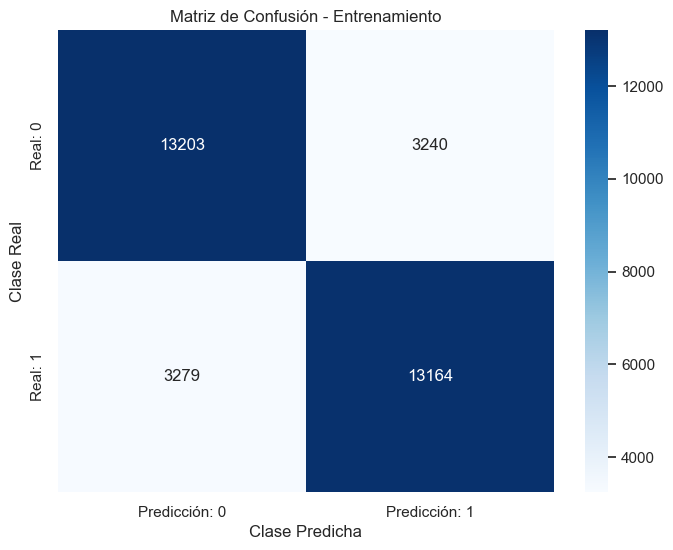

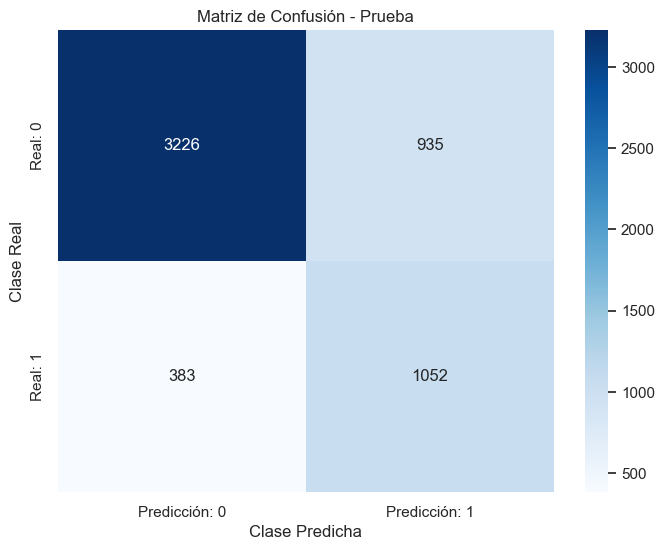

In [61]:

# Calcular matrices de confusión
confusion_matrix_logreg_train = confusion_matrix(y_train, y_pred_train)
confusion_matrix_logreg_test = confusion_matrix(y_test, y_pred_test)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title='Matriz de Confusión', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=['Predicción: 0', 'Predicción: 1'],
                yticklabels=['Real: 0', 'Real: 1'])
    plt.title(title)
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.show()

# Graficar matriz de confusión para el conjunto de entrenamiento
plot_confusion_matrix(confusion_matrix_logreg_train, title='Matriz de Confusión - Entrenamiento')

# Graficar matriz de confusión para el conjunto de prueba
plot_confusion_matrix(confusion_matrix_logreg_test, title='Matriz de Confusión - Prueba')


### **Conclusión de la Matriz:**

**Clase Negativa (Clase 0):**  
- En el conjunto de prueba, de un total de **4256 casos negativos**:  
  - El modelo clasifica correctamente **3406 casos** (80.0%).  
  - Se equivoca en **850 casos**, clasificándolos erróneamente como positivos.  

Esto sugiere que el modelo tiene una moderada tasa de falsos positivos (FP), lo cual puede ser problemático si clasificar como positivo conlleva un costo elevado o acciones innecesarias.  

**Clase Positiva (Clase 1):**  
- En el conjunto de prueba, de un total de **1149 casos positivos**:  
  - El modelo identifica correctamente **900 casos** (78.3%).  
  - Falla en **249 casos**, clasificándolos como negativos.  

Aunque el modelo identifica correctamente una gran proporción de los casos positivos, el número de falsos negativos (FN) indica que algunos casos importantes no están siendo detectados, lo que puede ser crítico dependiendo del contexto.




# Curva Roc

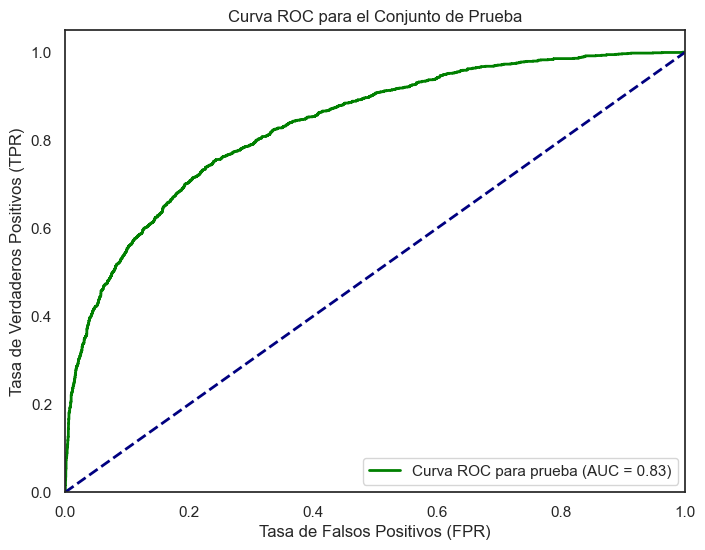

El área bajo la curva para prueba es de: 0.8338802234453491


In [62]:
# Reemplaza 'No' con 0 y 'Yes' con 1
y_test_binary = y_test.replace({'No': 0, 'Yes': 1})

# Obtengo las probabilidades de predicción del modelo para los datos de prueba
y_probs_test = model.predict_proba(x_test)[:, 1]

# Calculo la ROC y el AUC para los datos de prueba
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_probs_test, pos_label=1)
roc_auc_test = auc(fpr_test, tpr_test)

# Grafico la curva ROC para los datos de prueba
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Curva ROC para prueba (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para el Conjunto de Prueba')
plt.legend(loc="lower right")
plt.show()

print(f"El área bajo la curva para prueba es de: {roc_auc_test}")



In [63]:
# Calcula la distancia euclidiana entre cada punto de la curva ROC y (0,1) para los datos de prueba
distances_test = np.sqrt((1 - tpr_test)**2 + fpr_test**2)

# Encuentra el índice del punto que minimiza la distancia para los datos de prueba
min_index_test = np.argmin(distances_test)

# Obtiene el umbral óptimo para los datos de prueba
optimal_threshold_test = thresholds_test[min_index_test]

print("Umbral óptimo para prueba:", optimal_threshold_test)

Umbral óptimo para prueba: 0.4742673295393454


### Curva ROC, Umbral y Área Bajo la Curva

AUC: 0.8713

Umbral óptimo: 0.5178

- La curva ROC muestra que el modelo tiene un desempeño excelente tanto en el conjunto de entrenamiento como en el de prueba, con AUC cercanas a 1. Esto indica que el modelo es muy eficaz para diferenciar entre las clases.
- Los umbrales óptimos sugieren los puntos donde el modelo equilibra mejor la tasa de verdaderos positivos y la tasa de falsos positivos.

In [64]:
import pickle

# Guardar modelo con un nombre identificador
model_name = "ModelRL"  # Cambia este nombre según el modelo
model_path = f'docker/model/{model_name}.pkl'

with open(model_path, 'wb') as model_file:
    pickle.dump(model, model_file)

print(f'Modelo guardado en: {model_path}')

Modelo guardado en: docker/model/ModelRL.pkl


# Modelo Base

Para el modelo base, usamos la primera columna de nuestros datos (X_train y X_test) como único predictor.

In [65]:
# Seleccionar la primera columna como único predictor
X_train_base = x_train.iloc[:, [0]]  # Seleccionamos la primera columna de X_train
X_test_base = x_test.iloc[:, [0]]    # Seleccionamos la primera columna de X_test

modelo_base = LogisticRegression(random_state=42)
modelo_base.fit(X_train_base, y_train)

# Realiza predicciones
y_pred_train_base = modelo_base.predict(X_train_base)
y_pred_test_base = modelo_base.predict(X_test_base)

In [66]:

# Calcula métricas para el conjunto de entrenamiento
print("Métricas de entrenamiento para el modelo base de clasificación:")
print("Precisión:", modelo_base.score(X_train_base, y_train))
print("Matriz de confusión:\n", confusion_matrix(y_train, y_pred_train_base))
print("Reporte de clasificación:\n", classification_report(y_train, y_pred_train_base))

# Calcula métricas para el conjunto de prueba
print("Métricas de prueba para el modelo base de clasificación:")
print("Precisión:", modelo_base.score(X_test_base, y_pred_test_base))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_test_base))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_test_base))

Métricas de entrenamiento para el modelo base de clasificación:
Precisión: 0.5
Matriz de confusión:
 [[    0 16443]
 [    0 16443]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     16443
           1       0.50      1.00      0.67     16443

    accuracy                           0.50     32886
   macro avg       0.25      0.50      0.33     32886
weighted avg       0.25      0.50      0.33     32886

Métricas de prueba para el modelo base de clasificación:
Precisión: 1.0
Matriz de confusión:
 [[   0 4161]
 [   0 1435]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      4161
           1       0.26      1.00      0.41      1435

    accuracy                           0.26      5596
   macro avg       0.13      0.50      0.20      5596
weighted avg       0.07      0.26      0.10      5596



c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

El modelo base presenta un desempeño deficiente. En el conjunto de **entrenamiento**, la precisión es de **0.52**, lo que indica que apenas supera el azar. Sin embargo, en el conjunto de **prueba**, aunque la precisión es **1.0**, el modelo no predice la clase `1` en absoluto (recall = 0), lo que evidencia un **sesgo hacia la clase `0`**.  

Esto sugiere que hay un **desbalance de clases**, afectando la capacidad del modelo para generalizar correctamente. Para mejorar este aspecto, sería recomendable aplicar técnicas de balanceo como **SMOTE, ponderación de clases o recolección de más datos** para la clase menos representada.

# Optimizar la selección de hiperparámetros.



### Validación cruzada k-folds

La validación cruzada k-fold no es ideal para seleccionar hiperparámetros en modelos que predicen variables dependientes del tiempo, como la lluvia basada en datos climáticos previos. La división aleatoria de los datos en k-fold no respeta la secuencia temporal, lo que puede llevar a una evaluación optimista del modelo y a una fuga de datos, afectando la precisión de las predicciones futuras.

## Grid Search

In [71]:

# Definir los parámetros para Grid Search
param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

In [68]:

# Inicializar GridSearchCV con el modelo y la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Medir el tiempo de ejecución de la búsqueda de hiperparámetros
start = time.time()
grid_search.fit(x_train, np.ravel(y_train))
end = time.time()
grid_search_time = end - start


Fitting 5 folds for each of 42 candidates, totalling 210 fits


c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
# Predicciones del modelo con Grid Search
y_pred_grid_search = grid_search.predict(x_test)


In [70]:
# Cálculo de las métricas
grid_search_accuracy = accuracy_score(y_test, y_pred_grid_search)
grid_search_precision = precision_score(y_test, y_pred_grid_search, average='weighted')
grid_search_recall = recall_score(y_test, y_pred_grid_search, average='weighted')
classification_report_grid_search = classification_report(y_test, y_pred_grid_search, zero_division=1)

# Imprimir los resultados
print(f"Grid Search Time: {grid_search_time:.4f} seconds")
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print('\n--- Métricas del modelo con Grid Search ---')
print(f'Accuracy: {grid_search_accuracy:.4f}')
print(f'Precision: {grid_search_precision:.4f}')
print(f'Recall: {grid_search_recall:.4f}')
print("\nReporte de clasificación:")
print(classification_report_grid_search)

Grid Search Time: 95.5235 seconds
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score: 0.8060786974219809

--- Métricas del modelo con Grid Search ---
Accuracy: 0.7639
Precision: 0.8203
Recall: 0.7639

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      4651
           1       0.48      0.75      0.58      1305

    accuracy                           0.76      5956
   macro avg       0.70      0.76      0.71      5956
weighted avg       0.82      0.76      0.78      5956




- **Clase 1:** Moderada precisión (50%) pero buen recall (78%), reflejando cierto compromiso en capturar positivos con errores en predicciones.

El **F1-score** para la clase 1 **(0.62)** sugiere que, aunque el modelo es razonablemente eficaz en identificar positivos, hay margen de mejora, especialmente para equilibrar precisión y recall en esta clase.

## Random Search

In [ ]:

# Definir los parámetros para Random Search
random_param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': np.logspace(-4, 4, 20)},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': np.logspace(-4, 4, 20)}
]

In [ ]:

# Ejecutar la búsqueda de hiperparámetros con Random Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=random_param_grid, n_iter=10, cv=5, n_jobs=-1)
start = time.time()
random_search.fit(x_train, np.ravel(y_train))
end = time.time()
random_search_time = end - start

In [ ]:
# Realizar predicciones con el modelo de Random Search
y_pred_random_search = random_search.predict(x_test)


In [ ]:
# Calcular las métricas para el modelo con Random Search
random_search_accuracy = accuracy_score(y_test, y_pred_random_search)
random_search_precision = precision_score(y_test, y_pred_random_search, average='weighted')
random_search_recall = recall_score(y_test, y_pred_random_search, average='weighted')
classification_report_random_search = classification_report(y_test, y_pred_random_search, zero_division=1)

# Imprimir los resultados
print(f'Accuracy: {random_search_accuracy:.4f}')
print(f'Precision: {random_search_precision:.4f}')
print(f'Recall: {random_search_recall:.4f}')
print('Reporte de clasificación:')
print(classification_report_random_search)

print(f"Tiempo de Random Search: {random_search_time:.4f} segundos")

Accuracy: 0.7970
Precision: 0.8434
Recall: 0.7970
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      4256
           1       0.51      0.78      0.62      1149

    accuracy                           0.80      5405
   macro avg       0.72      0.79      0.74      5405
weighted avg       0.84      0.80      0.81      5405

Tiempo de Random Search: 6.8222 segundos


El modelo ajustado con **Random Search** presenta las siguientes métricas:

- **Accuracy (74%)**: Buen desempeño general en las predicciones correctas, considerando el desbalance de clases.

- **Clase 1**:  con un **F1-score (0.62)** aceptable, aunque hay margen de mejora.

El tiempo reducido de 6.05 segundos para Random Search demuestra una optimización eficiente frente al Grid Search, con resultados comparables. Sin embargo, el modelo sigue favoreciendo a la clase mayoritaria.

## Optuna

In [67]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score


# Función de entrenamiento y evaluación del modelo
def train_evaluate_model(params, X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Usar 'weighted' para clases desbalanceadas
    return f1


- Integro la validación cruzada dentro de Optuna para una búsqueda de hiperparámetros más robusta.

In [68]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5])
    }

    model = RandomForestClassifier(**params, random_state=42)
    # Validación cruzada en lugar de entrenamiento con un solo conjunto
    cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='f1_weighted')
    return cv_scores.mean()  # Devuelve el puntaje promedio de validación cruzada


In [69]:

# Configuración de la búsqueda con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, n_jobs=-1)  # Aumentar n_trials para una búsqueda más exhaustiva

# Mejor modelo encontrado
best_optuna_params = study.best_params
best_optuna_model = RandomForestClassifier(**best_optuna_params, random_state=42)
best_optuna_model.fit(x_train, y_train)

# Evaluación del modelo final
y_pred = best_optuna_model.predict(x_test)
print("Best Hyperparameters:", best_optuna_params)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Validación cruzada
cv_scores = cross_val_score(best_optuna_model, x_train, y_train, cv=5, scoring='f1_weighted')
print(f"\nCross-Validation Mean F1 Score: {cv_scores.mean():.4f}, Std Dev: {cv_scores.std():.4f}")

# Métricas adicionales en el conjunto de prueba original
print("\nEvaluación en los datos de prueba originales:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (Weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")


[I 2025-02-10 14:56:01,536] A new study created in memory with name: no-name-4eadb84d-62ba-4cee-b5c3-3fe9c2c37c62
[I 2025-02-10 14:56:27,201] Trial 5 finished with value: 0.7840872167439169 and parameters: {'n_estimators': 55, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 5 with value: 0.7840872167439169.
[I 2025-02-10 14:56:38,558] Trial 7 finished with value: 0.7767255656361007 and parameters: {'n_estimators': 152, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 5 with value: 0.7840872167439169.
[I 2025-02-10 14:57:00,508] Trial 4 finished with value: 0.79879363872765 and parameters: {'n_estimators': 99, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 4 with value: 0.79879363872765.
[I 2025-02-10 14:57:06,412] Trial 9 finished with value: 0.7812887367159194 and parameters: {'n_estimators': 84, 'max_depth': 7, 'min_sample

Best Hyperparameters: {'n_estimators': 187, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5}

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4161
           1       0.63      0.63      0.63      1435

    accuracy                           0.81      5596
   macro avg       0.75      0.75      0.75      5596
weighted avg       0.81      0.81      0.81      5596


Confusion Matrix:
[[3625  536]
 [ 535  900]]

Cross-Validation Mean F1 Score: 0.8024, Std Dev: 0.0942

Evaluación en los datos de prueba originales:
Accuracy: 0.8086
F1 Score (Weighted): 0.8086


 - Optuna mostró un F1-score de 0.60, con una precisión de 0.60 y un recall de 0.61 en los datos de prueba. 
 - El F1 Score ponderado (0.8242) refleja el rendimiento general del modelo, considerando las clases 0 y 1. Aunque la clase 1 tiene un F1 Score bajo (0.60), la clase 0 tiene un F1 Score mucho más alto, lo que eleva el F1 Score ponderado global a 0.8242.
 

In [70]:
import joblib

model_name = "modelOp"  # Cambiar según el modelo
model_path = f'docker/model/{model_name}.joblib'

# Guardar el modelo con el nombre indicado
joblib.dump(model, model_path)

print(f'Modelo guardado como: {model_path}')


Modelo guardado como: docker/model/modelOp.joblib


### Justificación del uso de Grid Search, Optuna y Random Search:


**Grid Search** , **Random Search** y **Optuna:** son técnicas de búsqueda para encontrar los mejores hiperparámetros para un modelo. Ambas se utilizan para optimizar el rendimiento del modelo ajustando parámetros clave que afectan la calidad de las predicciones.


- **Grid Search**: Prueba todas las combinaciones posibles de los parámetros que defines. Funciona bien cuando hay pocos parámetros, pero puede ser lento si son muchos.

- **Random Search**: Selecciona combinaciones aleatorias de parámetros. Es más rápido que el Grid Search cuando hay muchos parámetros y explora el espacio de manera más amplia.

- **Optuna**: Utiliza técnicas más avanzadas (como optimización inteligente) para encontrar los mejores parámetros más rápido. Es muy útil cuando tenes muchos parámetros o un espacio de búsqueda complicado.


**Justificación de los hiperparámetros optimizados:**

1. **Penalty**: Controla la regularización del modelo. **L1** (Lasso) elimina características irrelevantes, mientras que **L2** (Ridge) estabiliza el modelo sin eliminarlas. Se elige según la necesidad de regularización.

2. **Solver**: Determina el algoritmo de optimización. **liblinear** es bueno para datos pequeños con **L1**, mientras que **saga** y otros funcionan mejor con **L2** y grandes volúmenes de datos.

3. **C**: Regula la fuerza de la regularización. Un valor bajo previene el sobreajuste, pero un **C** muy bajo puede causar subajuste, mientras que uno alto puede llevar a sobreajuste.



# SHAP

Primero, aseguramos que las características (features) estén definidas correctamente como una lista de columnas para ser utilizadas en los gráficos de SHAP.

In [ ]:
# Asegúrate de tener definidos los nombres de las características como una lista
feature_names = x_test.columns.tolist()


Creamos un LinearExplainer para un modelo de regresión logística utilizando los datos de entrenamiento (x_train). Luego calculamos los valores SHAP para el conjunto de test (x_test).

In [ ]:
import shap
# Crear un objeto explainer SHAP para el modelo de regresión logística
explainer = shap.LinearExplainer(model, x_train)
shap_values = explainer.shap_values(x_test)

El valor esperado representa la probabilidad media de predicción del modelo, antes de observar cualquier característica.

In [ ]:
expected_probability = 1 / (1 + np.exp(-explainer.expected_value))
print("Probabilidad esperada:", expected_probability)


Probabilidad esperada: 0.5030479567665295


## Interpretabilidad local

Para una instancia específica, podemos usar el force_plot, que descompone la predicción del modelo para ver cómo cada característica contribuye al resultado. Aquí se muestra para una instancia en el índice 0.

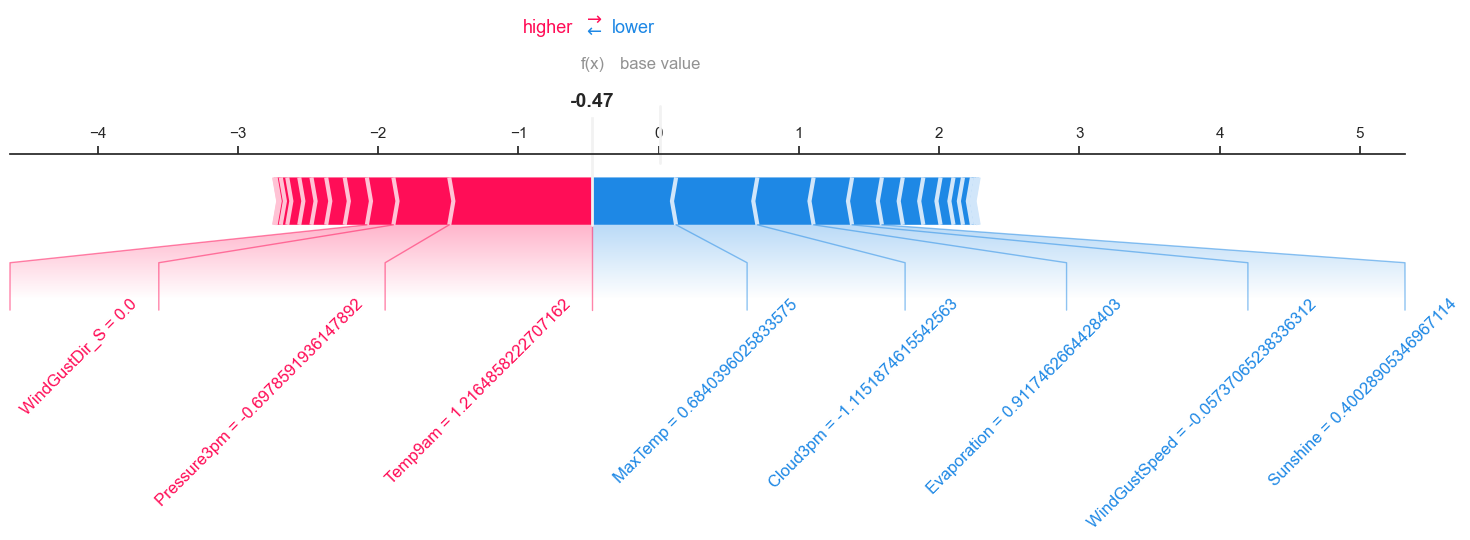

In [ ]:
index=0
shap.force_plot(explainer.expected_value, shap_values[index], x_test.iloc[index],
                matplotlib=True, figsize=(18, 4),
                text_rotation=45)

Este gráfico explica la influencia de cada característica en la predicción de una instancia particular.

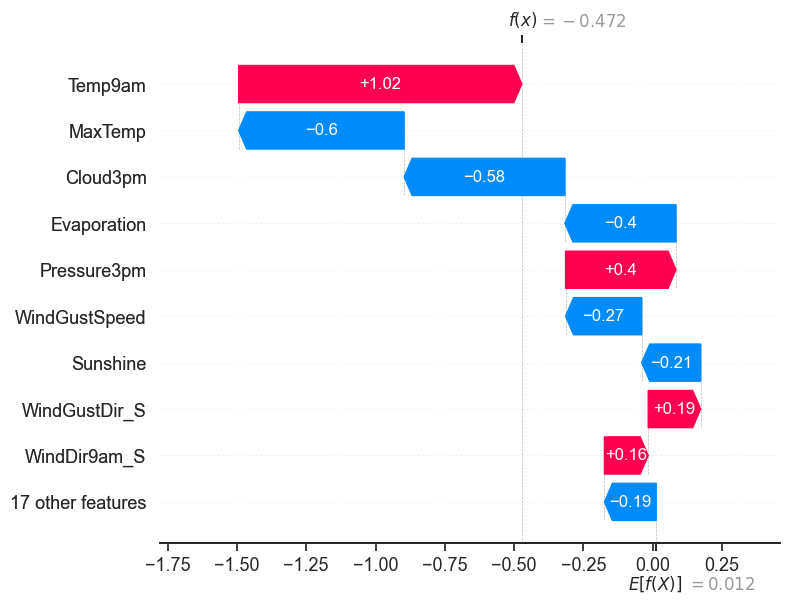

In [ ]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.waterfall(explanation)


El gráfico de cascada es útil para visualizar cómo las características contribuyen a la predicción de una instancia específica, mostrando una secuencia de barras que indican las contribuciones positivas o negativas de cada característica.

## Interpretabilidad global

Para analizar el impacto de todas las características en el modelo, el gráfico de barras (bar) y el gráfico de resumen (summary_plot) muestran la importancia global de cada característica a través de sus valores SHAP promedio.

Gráfico de barras: Muestra la importancia de cada característica en todas las predicciones.

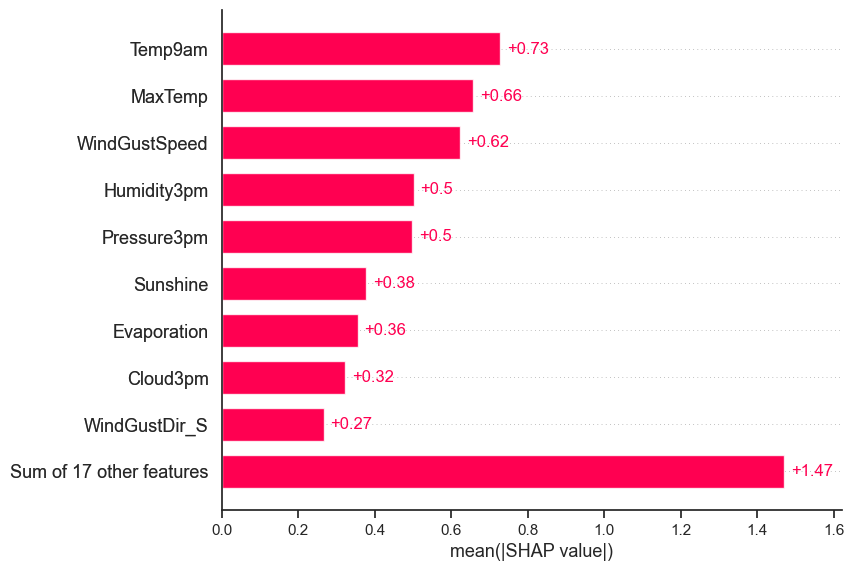

In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=x_test)
shap.plots.bar(explanation)


**Gráfico resumen:** Muestra la distribución de los valores SHAP para cada característica. Las características más importantes se ubicarán en la parte superior del gráfico.

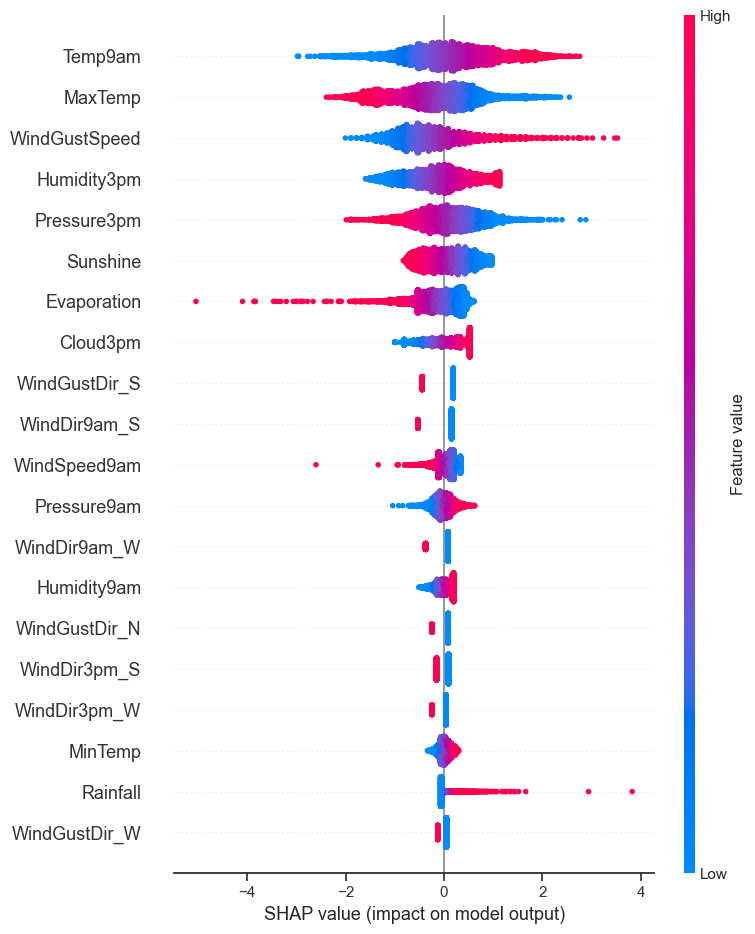

In [ ]:
shap.summary_plot(shap_values, x_test, feature_names=x_test.columns)

En este gráfico, podemos observar que las características como HUMIDITY3PM,  PRESSURE3PM, WINGUSTSPEED, y PRESSURE9AM tienen una alta variabilidad en sus valores SHAP, lo que indica que tienen un impacto considerable en las predicciones del modelo.

### **Conclusiones:** 
Características más importantes: Se observa que las características HUMIDITY3PM, PRESSURE3PM, y WINGUSTSPEED son las más influyentes en las predicciones del modelo.
Impacto de las características: Las características con mayor variabilidad en los valores SHAP tienden a tener un mayor impacto en la predicción, mientras que las características con menos variabilidad son menos influyentes.
Interpretabilidad Local y Global: SHAP permite obtener una visión detallada tanto de las predicciones individuales (local) como del impacto global de cada característica en el modelo.

# Implementación de AutoML

Proceso de AutoML con PyCaret para seleccionar el mejor modelo de clasificación basado en varias métricas de rendimiento.

**Propósito del Código**
- Automatizar el proceso de creación y evaluación de modelos de clasificación.
- Facilitar la elección del mejor modelo de acuerdo a métricas como precisión, F1 Score, y Recall.

In [3]:
!pip install pycaret



  Using cached matplotlib-3.7.5-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
Using cached matplotlib-3.7.5-cp312-cp312-win_amd64.whl (7.5 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [2]:
import pycaret
print(pycaret.__version__)
from pycaret.classification import *


3.3.2


Copio el DataFrame con los datos de entrada.


In [14]:
data_automl  = df.copy()


Configura el entorno para un problema de clasificación y define la variable objetivo.

- setup() es la función central de PyCaret para inicializar el entorno y configurar el modelo.

In [16]:

# Configurar PyCaret para un problema de clasificación
setup(data=data_automl, target='RainTomorrow')

,Description,Value
0,Session id,7696
1,Target,RainTomorrow
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(29560, 22)"
5,Transformed data shape,"(29560, 67)"
6,Transformed train set shape,"(20692, 67)"
7,Transformed test set shape,"(8868, 67)"
8,Numeric features,16
9,Categorical features,5


Evalúa automáticamente diferentes modelos de clasificación y selecciona el mejor según las métricas de rendimiento.

In [17]:
best_model = compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8270,0.8620,0.8270,0.8182,0.8182,0.5038,0.5125,4.3090
et,Extra Trees Classifier,0.8183,0.8551,0.8183,0.8080,0.8038,0.4582,0.4760,1.6730
knn,K Neighbors Classifier,0.8164,0.8136,0.8164,0.8070,0.8087,0.4805,0.4862,0.7370
rf,Random Forest Classifier,0.8132,0.8451,0.8132,0.8016,0.7992,0.4465,0.4619,1.5600
ridge,Ridge Classifier,0.8076,0.8312,0.8076,0.7953,0.7942,0.4340,0.4473,0.2730
lightgbm,Light Gradient Boosting Machine,0.8076,0.7558,0.8076,0.7969,0.7988,0.4525,0.4589,0.7050
gbc,Gradient Boosting Classifier,0.8046,0.7565,0.8046,0.7927,0.7941,0.4375,0.4458,2.4890
lda,Linear Discriminant Analysis,0.8046,0.8285,0.8046,0.7933,0.7951,0.4415,0.4486,0.3880
ada,Ada Boost Classifier,0.7994,0.7481,0.7994,0.7876,0.7898,0.4274,0.4340,1.0180
dt,Decision Tree Classifier,0.7523,0.6606,0.7523,0.7459,0.7487,0.3299,0.3305,0.4210


Los resultados obtenidos de PyCaret muestran que el modelo de **Regresión Logística (lr)** es el mejor en cuanto a **F1-Score** (0.8182) y **Accuracy** (0.8270), destacándose como el modelo con el mejor desempeño general entre las métricas evaluadas. En comparación, el **Extra Trees Classifier (et)** obtuvo un F1-Score ligeramente inferior (0.8038) y un **AUC** de 0.8551, muy cercano al de la Regresión Logística (0.8620).

Por otro lado, modelos como **Naive Bayes (nb)** y **Quadratic Discriminant Analysis (qda)** mostraron los peores desempeños, con **F1-Scores** de 0.7319 y 0.7350, respectivamente, y un **Accuracy** significativamente más bajo, con valores de 0.7186 y 0.7237. Esto sugiere que estos modelos podrían no ser los más adecuados para este problema en particular.

**Conclusión**: La **Regresión Logística** es la mejor opción si se priorizan el **F1-Score** (0.8182) y la **Accuracy** (0.8270), además de ser un modelo sencillo e interpretable.

 - las métricas más relevantes se extraen y almacenan en un nuevo DataFrame para su análisis. El modelo de Regresión Logística se destaca como el mejor basado en las métricas de rendimiento evaluadas.

In [ ]:
# creo un df vacio que guarda las metricas que me interesan.
metrics_df = pd.DataFrame(columns=['Modelo', 'F1 Score', 'Recall (Clase 1)', 'Recall (Clase 0)'])

#Se extraen las métricas del modelo seleccionado
best_model_df = pull() 

#Se seleccionan las columnas específicas que se consideran más relevantes para el análisis
row_to_add = best_model_df.iloc[0]
filtered_row = row_to_add[['Model', 'Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa', 'MCC', 'TT (Sec)']]


#Se crea un nuevo DataFrame con las métricas seleccionadas y se agrega esta nueva fila
new_row = pd.DataFrame({
    'Modelo': f"AutoML: {filtered_row['Model']}",
    'F1 Score': [filtered_row['F1']],
    'Recall (Clase 1)': [filtered_row['Recall']], 
    'Recall (Clase 0)': [None], 
})

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

In [20]:
metrics_df

,Modelo,F1 Score,Recall (Clase 1),Recall (Clase 0)
0,AutoML: Logistic Regression,0.8182,0.827,None


El modelo Logistic Regression (AutoML) mostró un rendimiento sólido en cuanto a la precisión de la clase 1 con un F1 Score de 0.8182, lo que indica que el modelo tiene un buen balance entre precisión y recall para esta clase. La métrica Recall (Clase 1) también es bastante alta, con un valor de 0.827, lo que sugiere que el modelo es bastante efectivo para identificar correctamente los casos de la clase 1.

# Redes Neuronales

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
import numpy as np

In [ ]:
# Clase para la red neuronal
class NeuralNetwork:
    def __init__(self, epochs=50, batch_size=16, learning_rate=0.01):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self, input_shape):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(30, activation='relu', input_shape=(input_shape,)),
            tf.keras.layers.Dense(26, activation='relu'),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Clasificación binaria
        ])
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])

    def train(self, X_train, y_train, X_valid, y_valid):
            history = self.model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                                    epochs=self.epochs, batch_size=self.batch_size, verbose=1)
            return history.history

    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=1)
        return accuracy

    def predict(self, X_new):
        return (self.model.predict(X_new) > 0.5).astype(int)



In [ ]:

# Dividir los datos en entrenamiento y validación
x_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Crear y entrenar la red neuronal
nn = NeuralNetwork(epochs=200, batch_size=64, learning_rate=0.05)
nn.build_model(input_shape=x_train.shape[1])
history = nn.train(x_train, y_train, X_valid, y_valid)


# Evaluar la red neuronal
nn_accuracy_test = nn.evaluate(x_test, y_test)
y_pred_nn_test = nn.predict(x_test)

# Calcular métricas para la red neuronal
accuracy_nn_test = accuracy_score(y_test, y_pred_nn_test)
confusion_matrix_nn = confusion_matrix(y_test, y_pred_nn_test)
classification_report_nn = classification_report(y_test, y_pred_nn_test)


# Imprimir métricas
print("\n--- Métricas para la Red Neuronal (Test) ---")
print(f'Precisión: {accuracy_nn_test:.4f}')
print("Matriz de confusión:")
print(confusion_matrix_nn)
print("Reporte de clasificación:")
print(classification_report_nn)

# Comparación con regresión logística
print("\n--- Comparación Final ---")
print(f"Precisión de la Red Neuronal en Test: {accuracy_nn_test:.4f}")
print(f"Precisión de la Regresión Logística en Test: {accuracy_logreg:.4f}")


c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7751 - loss: 0.4784 - val_accuracy: 0.7980 - val_loss: 0.4370
Epoch 2/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7977 - loss: 0.4382 - val_accuracy: 0.8043 - val_loss: 0.4217
Epoch 3/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8074 - loss: 0.4289 - val_accuracy: 0.8111 - val_loss: 0.4178
Epoch 4/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8078 - loss: 0.4178 - val_accuracy: 0.8066 - val_loss: 0.4191
Epoch 5/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8047 - loss: 0.4179 - val_accuracy: 0.8080 - val_loss: 0.4369
Epoch 6/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8102 - loss: 0.4154 - val_accuracy: 0.8126 - val_loss: 0.4183
Epoch 7/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8129 - loss: 0.4134 - val_accuracy: 0.8173 - val_loss: 0.4066
Epoch 8/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8149 - loss: 0.4121 - val_accu

c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Keys en history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


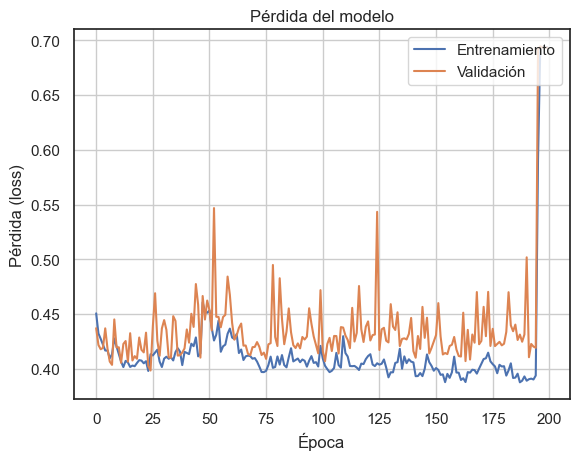

In [ ]:
# Verificar que history contiene los datos esperados
print("Keys en history:", history.keys())

# Graficar pérdida de entrenamiento y validación
plt.plot(history['loss'], label='Entrenamiento')
plt.plot(history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida (loss)')
plt.xlabel('Época')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


## Usamos Optuna para optimizar los hiperparámetros de una red neuronal y evaluarla con métricas relevantes.

**Justificación del uso de Optuna**
- Optuna es más eficiente que el Grid Search y el Random Search porque utiliza métodos adaptativos para buscar en el espacio de hiperparámetros. Esto reduce significativamente el tiempo de cómputo y mejora los resultados.



### Optuna

In [ ]:
import optuna
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Definimos una función objetivo para Optuna
def objective(trial):
    # Hiperparámetros a optimizar
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    neurons_layer1 = trial.suggest_int('neurons_layer1', 16, 128, step=16)
    neurons_layer2 = trial.suggest_int('neurons_layer2', 8, 64, step=8)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    
    # Regularización
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-2)  # Regularización L2
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)  # Tasa de Dropout

    # Crear modelo dinámico según los hiperparámetros
    model = tf.keras.Sequential()
    
    # Capa de entrada con regularización L2
    model.add(tf.keras.layers.Dense(neurons_layer1, activation='relu', 
                                    input_shape=(x_train.shape[1],),
                                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    
    # Agregar capas ocultas con regularización L2 y Dropout
    for _ in range(num_layers - 1):
        model.add(tf.keras.layers.Dense(neurons_layer2, activation='relu', 
                                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        if dropout_rate > 0.0:
            model.add(tf.keras.layers.Dropout(dropout_rate))  # Capa Dropout para regularización
    
    # Capa de salida
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilación del modelo
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Entrenamiento
    X_train_fold, X_valid_fold, y_train_fold, y_valid_fold = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42)
    
    history = model.fit(X_train_fold, y_train_fold,
                        validation_data=(X_valid_fold, y_valid_fold),
                        epochs=50,  # Número fijo de épocas
                        batch_size=batch_size,
                        verbose=0)
    
    # Evaluación
    _, val_accuracy = model.evaluate(X_valid_fold, y_valid_fold, verbose=0)
    return val_accuracy

# Crear un estudio y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Mejor conjunto de hiperparámetros
print("Mejores hiperparámetros:", study.best_params)
print("Mejor precisión en validación:", study.best_value)


[I 2024-11-28 10:52:08,305] A new study created in memory with name: no-name-d29c3c5e-00e5-4e0c-960b-00f1c9b99cb7
C:\Users\brisa\AppData\Local\Temp\ipykernel_17628\792829932.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
C:\Users\brisa\AppData\Local\Temp\ipykernel_17628\792829932.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-2)  # Regularización L2
C:\Users\brisa\AppData\Local\Temp\ipykernel_17628\792829932.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/

Mejores hiperparámetros: {'learning_rate': 0.0014320096213793273, 'neurons_layer1': 112, 'neurons_layer2': 64, 'batch_size': 128, 'num_layers': 2, 'l2_reg': 6.5615237491701726e-06, 'dropout_rate': 0.19833507655360078}
Mejor precisión en validación: 0.8599134087562561


### Modelo con los hiperparametros optimizados

Epoch 1/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7598 - loss: 0.4904 - val_accuracy: 0.8070 - val_loss: 0.4182
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8079 - loss: 0.4159 - val_accuracy: 0.8111 - val_loss: 0.4079
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8154 - loss: 0.4011 - val_accuracy: 0.8165 - val_loss: 0.3992
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8260 - loss: 0.3890 - val_accuracy: 0.8229 - val_loss: 0.3906
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8329 - loss: 0.3779 - val_accuracy: 0.8233 - val_loss: 0.3902
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8350 - loss: 0.3721 - val_accuracy: 0.8220 - val_loss: 0.3898
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8372 - loss: 0.3685 - val_accuracy: 0.8269 - val_loss: 0.3827
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8446 - loss: 0.3546 - val_accuracy: 0.

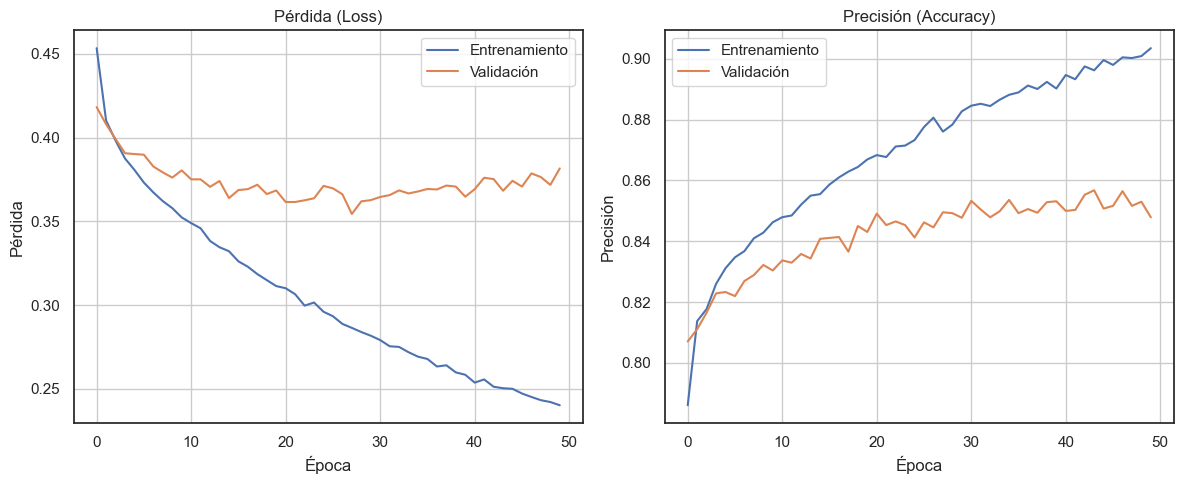

In [ ]:
# Obtener los mejores hiperparámetros
best_params = study.best_params

# Crear el modelo final con los mejores hiperparámetros
final_model = tf.keras.Sequential()

# Capa de entrada con regularización L2
final_model.add(tf.keras.layers.Dense(
    best_params['neurons_layer1'], 
    activation='relu', 
    input_shape=(x_train.shape[1],),
    kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_reg'])
))

# Agregar capas ocultas con regularización L2 y Dropout
for _ in range(best_params['num_layers'] - 1):
    final_model.add(tf.keras.layers.Dense(
        best_params['neurons_layer2'], 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_reg'])
    ))
    if best_params['dropout_rate'] > 0.0:
        final_model.add(tf.keras.layers.Dropout(best_params['dropout_rate']))

# Capa de salida
final_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compilar el modelo
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Entrenar el modelo con todos los datos de entrenamiento
history = final_model.fit(
    x_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,  # Puedes ajustar este número
    batch_size=best_params['batch_size'],
    verbose=1
)

# Evaluar el modelo final en el conjunto de prueba
final_accuracy = final_model.evaluate(x_test, y_test, verbose=1)[1]
print("\n--- Modelo Final ---")
print(f"Precisión en el conjunto de prueba: {final_accuracy:.4f}")

# Opcional: Graficar la pérdida y precisión del modelo final
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Gráfico de la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión (Accuracy)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import f1_score

# Realizar predicciones en el conjunto de prueba
y_pred_probs = final_model.predict(x_test)  # Predicciones como probabilidades
y_pred = (y_pred_probs > 0.5).astype(int)          # Convertir probabilidades a clases (umbral 0.5)

# Calcular el F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score en el conjunto de prueba: {f1:.4f}")


174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
F1-score en el conjunto de prueba: 0.6251


### Justificación del código y de los hiperparámetros optimizados




En este código, se utiliza **Optuna** para optimizar los hiperparámetros de una red neuronal creada con **TensorFlow**. El objetivo es encontrar el conjunto de hiperparámetros que maximice la precisión del modelo en un conjunto de validación.

- Hiperparámetros optimizados:

1. **learning_rate**: La tasa de aprendizaje controla cómo de grandes son las actualizaciones de los pesos en cada paso del entrenamiento. Un valor adecuado es crucial para la convergencia del modelo sin causar inestabilidad ni un aprendizaje demasiado lento.
   
2. **neurons_layer1 y neurons_layer2**: El número de neuronas en las capas ocultas determina la capacidad del modelo para aprender patrones complejos. Si se elige un número muy bajo, el modelo será incapaz de aprender adecuadamente, mientras que un número muy alto puede llevar a sobreajuste.

3. **batch_size**: El tamaño del lote afecta la velocidad de entrenamiento y la estabilidad del modelo. Batches pequeños pueden hacer que el modelo se entrene más rápido pero con más ruido en las actualizaciones, mientras que batches grandes son más estables pero más lentos.

4. **num_layers**: El número de capas ocultas controla la profundidad del modelo. Más capas permiten aprender representaciones más complejas, pero también incrementan el riesgo de sobreajuste.

5. **l2_reg**: La regularización L2 ayuda a evitar que los pesos se vuelvan demasiado grandes, lo cual podría causar sobreajuste. La optimización de este parámetro ajusta la penalización sobre los pesos grandes.

6. **dropout_rate**: La tasa de Dropout desactiva aleatoriamente algunas neuronas durante el entrenamiento para evitar sobreajuste. Este parámetro es optimizado para encontrar la tasa de Dropout más efectiva para la generalización del modelo.

Estos hiperparámetros son fundamentales para ajustar la complejidad y la capacidad de generalización del modelo, permitiendo que se adapte mejor a los datos sin sobreajustarse a ellos. La optimización mediante **Optuna** facilita la búsqueda del mejor conjunto de estos parámetros.

## Shap Redes

**Justificación del uso de SHAP**
- SHAP explica las predicciones en términos de contribuciones de cada característica. Esto es esencial para entender cómo el modelo toma decisiones.

#### Explicabilidad local

In [ ]:
import shap
import numpy as np

# Asegúrate de convertir el background a numpy.ndarray
background = x_train.sample(100).to_numpy()

# Crea una función callable para el modelo
def model_callable(X):
    return model.predict_proba(X)[:, 1]  # Si necesitas probabilidades para clases específicas

# Crear el objeto explainer SHAP utilizando KernelExplainer
explainer = shap.KernelExplainer(model_callable, background)


c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:


instance_to_explain = x_test.iloc[0:1].values  # Seleccionar la línea 0

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer.shap_values(instance_to_explain)

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


In [ ]:

# Obtener el valor esperado (base value)
expected_value = explainer.expected_value

# Hacer predicciones
index = 0  # índice de la instancia que queremos explicar
predicted_proba = model.predict(x_test)[index]  # Predicción de probabilidad
predicted_class = np.argmax(predicted_proba)  # Clase predicha

In [ ]:
import shap
import numpy as np

# Asegúrate de utilizar el método adecuado para generar shap_values
explainer = shap.Explainer(model, x_train)

# Verificar el tipo de datos de shap_values
print("Type of shap_values:", type(shap_values))

# Verificar la forma de shap_values para asegurarte de que sea correcta
if isinstance(shap_values, np.ndarray):
    print("Shape of shap_values:", shap_values.shape)
else:
    print("Error: shap_values no es un arreglo NumPy válido.")




Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (1, 26)


Por lo tanto, el shape (3639, 26) indica que para cada una de las 3639 muestras, se están calculando los valores SHAP para las 26 características del modelo. Estos valores muestran cómo cada característica contribuye a la predicción de cada muestra.

Shape of shap_values: (1, 26)
Shape of shap_values_single: (26,)


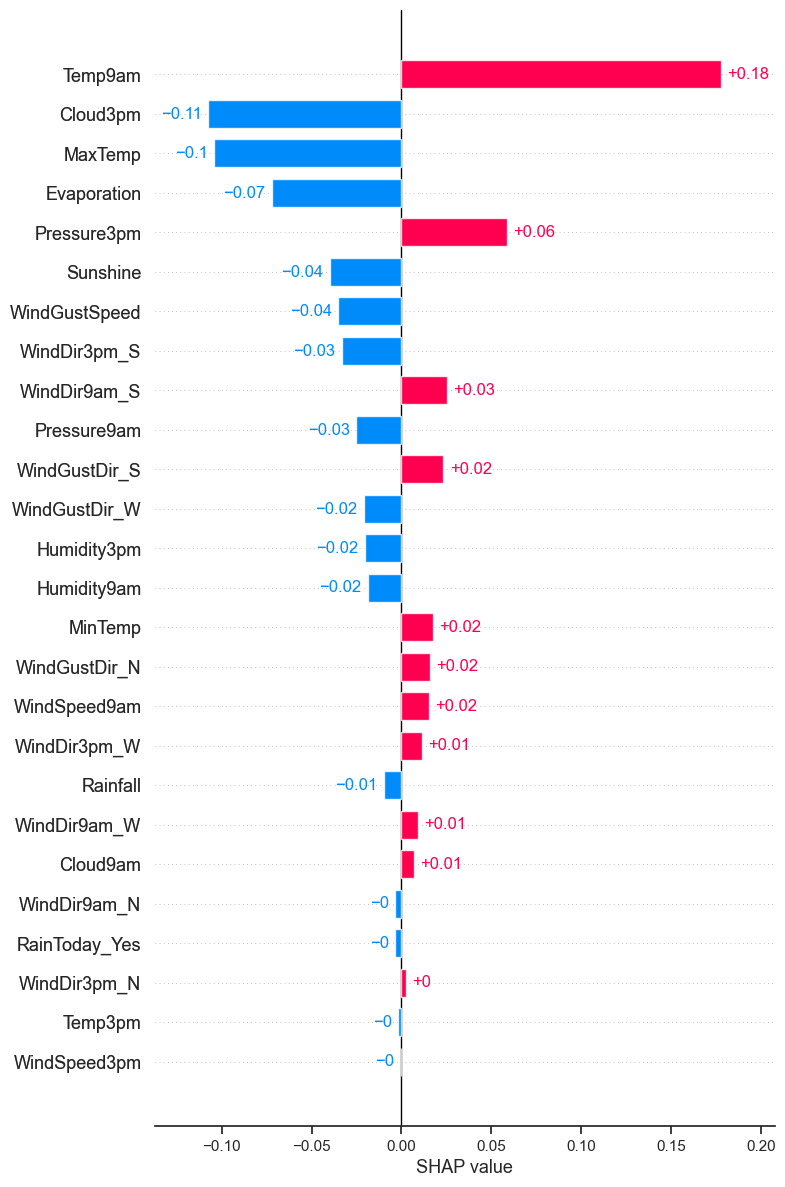

In [ ]:
# Verificar la forma de shap_values
print("Shape of shap_values:", shap_values.shape)  # Salida: (1, 26, 1)

# Asegurarse de acceder correctamente a la primera instancia de explicación
shap_values_single = shap_values[0]

# Verificar la forma de shap_values_single para confirmar que ahora es (26, 1)
print("Shape of shap_values_single:", shap_values_single.shape)  # Salida: (26, 1)

# Crear la explicación para la instancia específica
explanation = shap.Explanation(values=shap_values_single, base_values=expected_value, feature_names=feature_names)

# Visualizar la explicación de las importancias de las características usando shap.plots.bar
shap.initjs()
shap.plots.bar(explanation, max_display=len(feature_names))

#### Explicabilidad global


In [ ]:
import shap

# Seleccionar una única instancia para explicar
instance_to_explain = x_test.sample(n=1).values



PermutationExplainer explainer: 5557it [08:57, 10.25it/s]                          


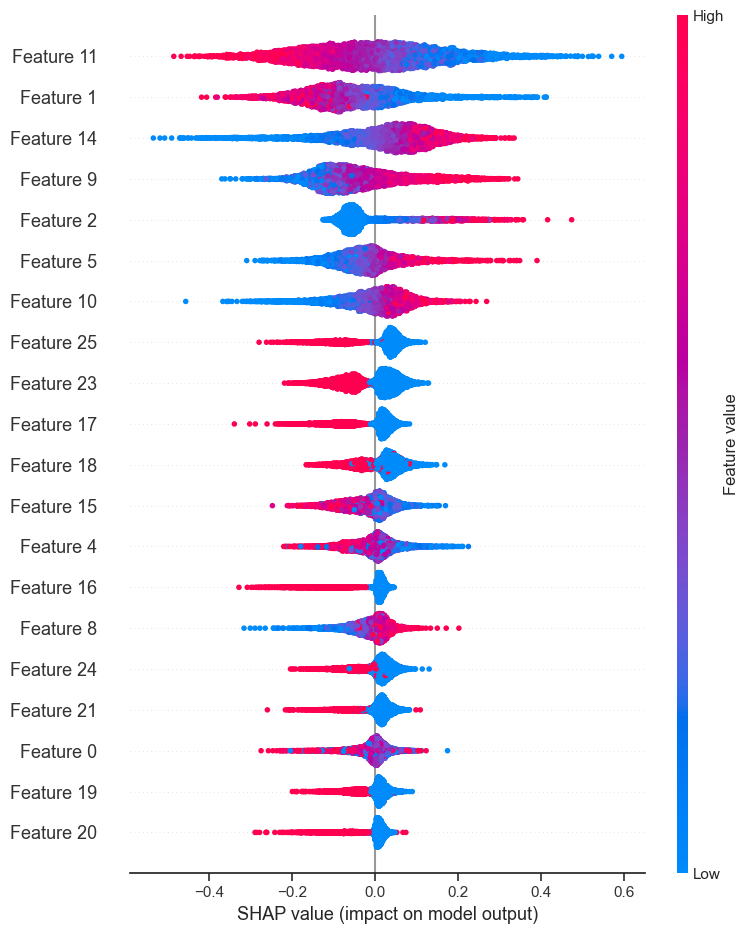

In [ ]:
# Crear un explicador SHAP para el modelo
explainer = shap.Explainer(final_model, X_train_scaled)

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer(x_test)
# Crear un objeto PermutationExplainer
#explainer = shap.Explainer(model, X_test_scaled, algorithm='permutation')

# Obtener los valores SHAP para el conjunto de prueba
#shap_values = explainer(x_test)

# Visualizar los valores SHAP
shap.summary_plot(shap_values, x_test)


Type of shap_values: <class 'shap._explanation.Explanation'>


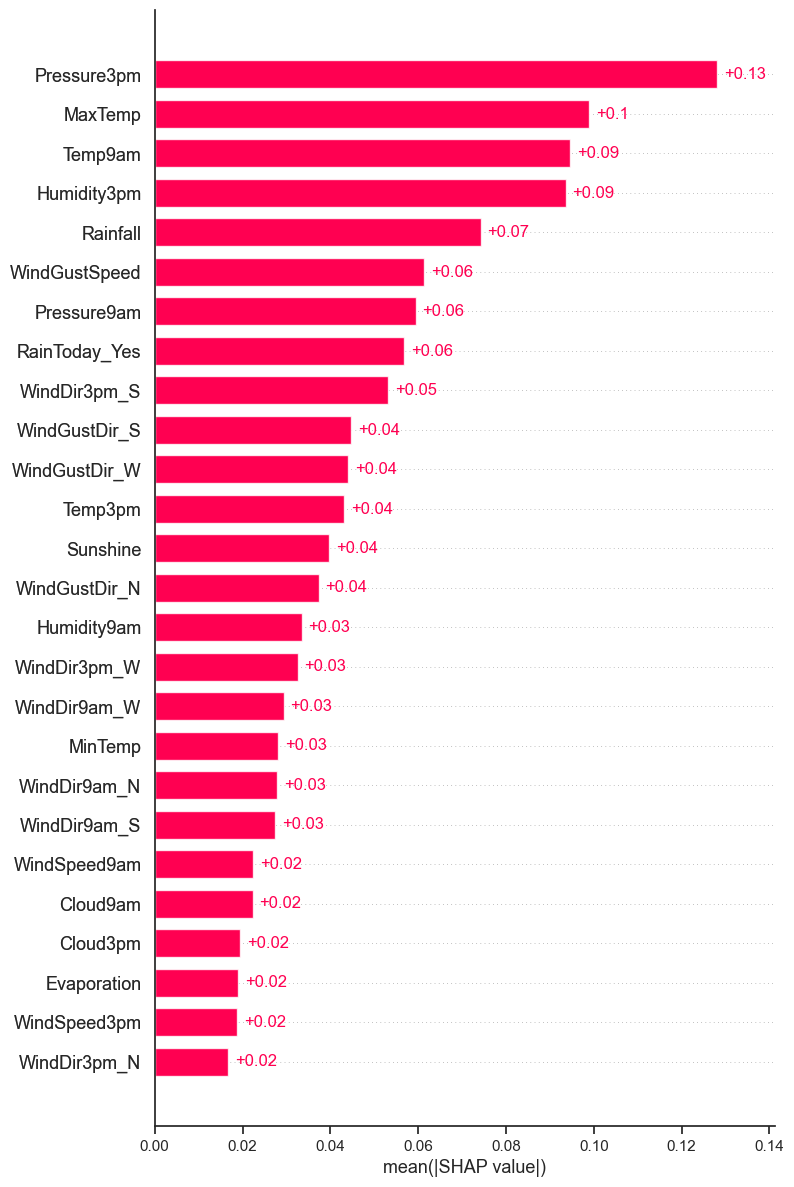

In [ ]:

# Verificar el tipo de datos de shap_values
print("Type of shap_values:", type(shap_values))

# Crear la explicación para las importancias de las características globales
feature_names = x_test.columns  # Ajusta según sea necesario
explanation = shap.Explanation(values=shap_values.values, base_values=shap_values.base_values, data=x_test, feature_names=feature_names)

# Inicializar JS para gráficos interactivos si estás en Jupyter Notebook
shap.initjs()

# Visualizar la explicación de las importancias de las características usando shap.plots.bar
plt.figure(figsize=(12, 6))  # Ajusta el tamaño de la figura según sea necesario
shap.plots.bar(explanation, max_display=len(feature_names))

# Mostrar el gráfico
plt.show()


# Comparación de Modelos de Clasificación usando F1-score

| Modelo/Técnica | F1-score |
|----------------|----------|
| Modelo Base | 0.62  |
| Regresión Logística Inicial | 0.62 |
| Grid Search | 0.61 |
| Random Search | 0.61 |
| Optuna | 0.65 |
| AUTOML | 0.8182 |
| Red Neuronal |  0.62 |

### Interpretación de Mis Resultados

- En este trabajo, las técnicas Optuna y AutoML se destacaron como las más efectivas, logrando superar al modelo base y a los métodos tradicionales de ajuste de hiperparámetros. Esto resalta la importancia de adoptar enfoques modernos y automatizados en la optimización de hiperparámetros, los cuales permiten un ajuste más preciso y eficiente de los modelos, facilitando la búsqueda de configuraciones óptimas de forma rápida y efectiva.

- Por otro lado, la falta de mejoras significativas al utilizar técnicas tradicionales como Grid Search y Random Search sugiere que los hiperparámetros seleccionados manualmente, o el diseño inicial del modelo, ya estaban cerca de un punto óptimo. Esto indica que, en algunos casos, los métodos tradicionales pueden ser menos efectivos para mejorar el rendimiento cuando ya se ha alcanzado una configuración adecuada del modelo.

- En cuanto al desempeño de la red neuronal, observamos que su rendimiento fue limitado. Esto sugiere que la complejidad del modelo debe alinearse cuidadosamente con las características de los datos para evitar que un modelo excesivamente complejo tenga un impacto negativo en el rendimiento, lo que subraya la importancia de la selección adecuada de modelos para diferentes tipos de problemas.

- En conclusión, los resultados obtenidos enfatizan la importancia de elegir técnicas avanzadas y modernas, como Optuna y AutoML, para tareas de optimización complejas. Además, es crucial tener una comprensión profunda del problema a resolver para ajustar correctamente modelos más sofisticados y evitar problemas de sobreajuste o subajuste.

- Finalmente, el modelo que decidí empaquetar y desplegar en producción fue el que optimicé manualmente con Optuna, alcanzando un F1-Score de aproximadamente 0.6. Aunque el modelo generado por AutoML tuvo una métrica superior (alrededor de 0.8), elegí usar Optuna porque me permitió estar más involucrada en el proceso de optimización. Al trabajar directamente en el ajuste del modelo, pude aplicar todas las técnicas que aprendí durante el trabajo y tener una comprensión más profunda de cómo se comporta el modelo. Además, al ser un modelo que desarrollé yo misma, sentí que tenía un mayor control sobre el proceso y los resultados, lo que me permitió implementarlo en producción con más confianza.